In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import svm
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Libraries used for Modelling
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree
#from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import re


In [ ]:
listingDF=pd.read_csv('/content/Data_Final.csv')

<ipython-input-2-17ff5e38943d>:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  listingDF=pd.read_csv('/content/Data_Final.csv')


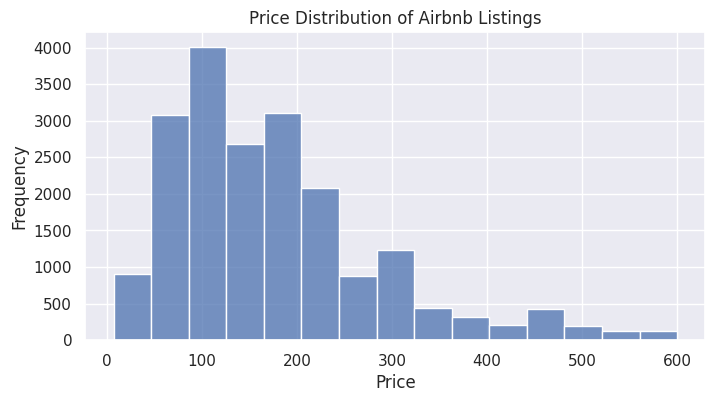

In [ ]:
plt.figure(figsize=(8, 4))
sb.histplot(listingDF['price'], bins=15, kde=False)
plt.title('Price Distribution of Airbnb Listings')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
listingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19817 entries, 0 to 19816
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           19817 non-null  int64  
 1   description                  19817 non-null  int64  
 2   host_id                      19817 non-null  int64  
 3   host_since                   19817 non-null  object 
 4   host_response_time           19817 non-null  int64  
 5   host_response_rate           19817 non-null  int64  
 6   host_acceptance_rate         19817 non-null  float64
 7   host_is_superhost            19817 non-null  int64  
 8   host_total_listings_count    19817 non-null  float64
 9   host_has_profile_pic         19817 non-null  int64  
 10  host_identity_verified       19817 non-null  int64  
 11  neighbourhood_cleansed       19817 non-null  object 
 12  latitude                     19817 non-null  float64
 13  longitude       

In [ ]:
# Drop the specified columns from the DataFrame
columns_to_drop = [
    'id', 'host_id', 'host_since', 'neighbourhood_cleansed', 'availability_365',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'City', 'z_score', 'tv',
    'netflix', 'gym', 'elevator', 'fridge', 'heating', 'hair_dryer',
    'air_conditioning', 'hot_tub', 'oven', 'bbq', 'security cameras', 'workspace',
    'coffee', 'backyard', 'outdoor_dining', 'greets', 'pool', 'beachfront', 'patio',
    'luggage', 'furniture','latitude', 'longitude','host_response_rate','host_has_profile_pic','host_response_time',
    'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication',
    'review_scores_location','review_scores_value'
]

newListingsDF = listingDF.drop(columns=columns_to_drop, errors='ignore')

# Display the first few rows of the modified DataFrame
newListingsDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19817 entries, 0 to 19816
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   description                19817 non-null  int64  
 1   host_acceptance_rate       19817 non-null  float64
 2   host_is_superhost          19817 non-null  int64  
 3   host_total_listings_count  19817 non-null  float64
 4   host_identity_verified     19817 non-null  int64  
 5   property_type              19817 non-null  object 
 6   room_type                  19817 non-null  object 
 7   accommodates               19817 non-null  int64  
 8   bathrooms                  19817 non-null  float64
 9   bedrooms                   19817 non-null  float64
 10  beds                       19817 non-null  float64
 11  amenities                  19817 non-null  object 
 12  price                      19817 non-null  float64
 13  minimum_nights             19817 non-null  int

#Amenities encoding

In [ ]:
import re

# Perform the specified replacements directly on the 'amenities' column of newListingsDF
newListingsDF['amenities'] = newListingsDF['amenities'].str.replace('[', '', regex=False)
newListingsDF['amenities'] = newListingsDF['amenities'].str.replace(']', '', regex=False)
newListingsDF['amenities'] = newListingsDF['amenities'].str.replace('"', '', regex=False)
newListingsDF['amenities'] = newListingsDF['amenities'].apply(lambda x: re.sub(r'\\\w+', '', x) if isinstance(x, str) else x)
newListingsDF['amenities'] = newListingsDF['amenities'].str.lower()

# Display the first few rows to verify the changes
newListingsDF['amenities'].head()


,amenities
0,"hot water, extra pillows and blankets, backyar..."
1,"hot water, outdoor dining area, ceiling fan, e..."
2,"free dryer in building, hot water, outdoor di..."
3,
4,"hot water, ceiling fan, extra pillows and blan..."


In [ ]:
# Creating a set of all possible amenities
amenities_list = list(newListingsDF.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.split(',')
# Converting the amenities_list into a DataFrame
amenities_df = pd.DataFrame(amenities_list_string, columns=["Amenity"])

# Display the first few rows of the amenities DataFrame
amenities_df.value_counts().head(30)

,count
Amenity,
smoke alarm,17946
kitchen,17452
wifi,16952
hangers,15326
carbon monoxide alarm,15044
fire extinguisher,14567
cooking basics,14432
microwave,14263
iron,14188


In [ ]:
# Creating column variables for each of the different amenities and adding them into the original dataframe
newListingsDF.loc[newListingsDF['amenities'].str.contains('air conditioning|central air conditioning|conditioning|ceiling fan'), 'air_conditioning'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('bbq grill|fire pit|propane barbeque|bbq'), 'bbq'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('bed linens'), 'bed_linen'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('tv'), 'tv'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('coffee maker|espresso machine'), 'coffee_machine'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('cooking basics|kitchen|dishwasher|microwave|dishes and silverware|oven|toaster'),
                  'cooking_basics'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('dryer|washer|free dryer in unit'), 'white_goods'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('exercise equipment|gym'), 'gym'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('parking|free street parking|free parking on premises	'), 'parking'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('garden|outdoor|sun loungers|terrace|balcony|patio|private patio or balcony'), 'outdoor_space'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('hot tub|jetted tub|sauna|pool'), 'hot_tub_sauna_or_pool'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('internet|pocket wifi|wifi'), 'internet'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('long term stays allowed'), 'long_term_stays'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('pets|cats|dogs|cat|dog'), 'pets_allowed'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('self check-in'), 'self_check_in'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('hangers|iron|hair dryer'), 'fashion'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('smoke alarm|carbon monoxide alarm|fire extinguisher'), 'alarm_system'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('first aid kit'), 'first_aid_kit'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('exterior security cameras on property|barbecue utensils|private entrance|dining table|room-darkening shades'),
                  'luxury'] = 1


In [ ]:
newListingsDF.isna().sum()

,0
description,0
host_acceptance_rate,0
host_is_superhost,0
host_total_listings_count,0
host_identity_verified,0
property_type,0
room_type,0
accommodates,0
bathrooms,0
bedrooms,0


In [ ]:
# To convert NaN values to 0 for preparation for Modelling
newListingsDF = newListingsDF.fillna(0)

In [ ]:
newListingsDF.drop('amenities', axis=1, inplace=True)

In [ ]:
newListingsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19817 entries, 0 to 19816
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   description                19817 non-null  int64  
 1   host_acceptance_rate       19817 non-null  float64
 2   host_is_superhost          19817 non-null  int64  
 3   host_total_listings_count  19817 non-null  float64
 4   host_identity_verified     19817 non-null  int64  
 5   property_type              19817 non-null  object 
 6   room_type                  19817 non-null  object 
 7   accommodates               19817 non-null  int64  
 8   bathrooms                  19817 non-null  float64
 9   bedrooms                   19817 non-null  float64
 10  beds                       19817 non-null  float64
 11  price                      19817 non-null  float64
 12  minimum_nights             19817 non-null  int64  
 13  maximum_nights             19817 non-null  int

In [ ]:
newListingsDF['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

# encoding property type

In [ ]:
# Define mapping
mapping = {
    'guesthouse': 'guesthouse',
    'casa': 'guesthouse', 'villa': 'guesthouse',
    'home': 'home','Entire place':'home','guest suite': 'guesthouse',
    'cabin': 'outdoor','barn': 'outdoor','loft': 'outdoor','cottage': 'outdoor','chalet': 'outdoor',
    'Adventure': 'outdoor','tent': 'outdoor','camper/rv': 'outdoor','tower':'outdoor',
    'hostel': 'hostel','hotel': 'hotel','resort': 'resort', 'bungalow':'bungalow',
    'apartment':'apartment', 'condo':'apartment', 'townhouse':'apartment', 'rental': 'hostel',
    'Private room':'Private_room','Alternative':'Private_room'
}

# Function to map property_type
def map_property_type(value):
    for key, replacement in mapping.items():
        if key.lower() in value.lower():
            return replacement
    return value

# Apply the mapping function to the dataframe
newListingsDF['property_type'] = newListingsDF['property_type'].apply(map_property_type)



In [ ]:
newListingsDF['property_type'].value_counts()

,count
property_type,
home,9280
hostel,5381
apartment,2427
guesthouse,1323
Private_room,386
outdoor,330
hotel,327
bungalow,304
resort,59


In [ ]:
'''# prompt: # Grouping property types with less than <100 count into 'Other'

# Group property types with less than 100 counts into 'Other'
property_type_counts = newListingsDF['property_type'].value_counts()
property_types_to_group = property_type_counts[property_type_counts < 200].index.tolist()
newListingsDF['property_type'] = newListingsDF['property_type'].apply(lambda x: 'Other' if x in property_types_to_group else x)'''

"# prompt: # Grouping property types with less than <100 count into 'Other'\n\n# Group property types with less than 100 counts into 'Other'\nproperty_type_counts = newListingsDF['property_type'].value_counts()\nproperty_types_to_group = property_type_counts[property_type_counts < 200].index.tolist()\nnewListingsDF['property_type'] = newListingsDF['property_type'].apply(lambda x: 'Other' if x in property_types_to_group else x)"

Transformation

In [ ]:
# One-hot encode the Categorial variables
transformedDF = pd.get_dummies(newListingsDF, columns=['room_type','property_type'])


In [ ]:
transformedDF.shape

(19817, 54)

In [ ]:
transformedDF.columns =transformedDF.columns.str.replace(' ', '_')

In [ ]:
transformedDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19817 entries, 0 to 19816
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   description                 19817 non-null  int64  
 1   host_acceptance_rate        19817 non-null  float64
 2   host_is_superhost           19817 non-null  int64  
 3   host_total_listings_count   19817 non-null  float64
 4   host_identity_verified      19817 non-null  int64  
 5   accommodates                19817 non-null  int64  
 6   bathrooms                   19817 non-null  float64
 7   bedrooms                    19817 non-null  float64
 8   beds                        19817 non-null  float64
 9   price                       19817 non-null  float64
 10  minimum_nights              19817 non-null  int64  
 11  maximum_nights              19817 non-null  int64  
 12  has_availability            19817 non-null  int64  
 13  number_of_reviews           198

In [ ]:
# prompt: convert boolean valued columns to 0 and 1

# Assuming 'transformedDF' is your DataFrame
for column in transformedDF.select_dtypes(include=['bool']).columns:
  transformedDF[column] = transformedDF[column].astype(int)

# Now, your boolean columns are converted to 0 and 1

#Scaling


In [ ]:
interval_cols = ['host_acceptance_rate','host_total_listings_count','accommodates',
                 'bathrooms', 'bedrooms', 'beds', 'minimum_nights','maximum_nights','number_of_reviews',
                 'review_scores_rating','reviews_per_month','host_duration_days',
                 'availability_30_ratio', 'availability_60_ratio','availability_90_ratio',
                 'amenities_count',]
ScaledDF = transformedDF.copy()
# Scale the interval features
scaler = MinMaxScaler()
ScaledDF[interval_cols] = scaler.fit_transform(ScaledDF[interval_cols])

#split data

In [ ]:
# Separating X and y for Modelling
X = ScaledDF.drop('price', axis=1)
y = ScaledDF['price']
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
X.head()

,description,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,has_availability,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,host_duration_days,availability_30_ratio,availability_60_ratio,availability_90_ratio,amenities_count,air_conditioning,bbq,bed_linen,tv,coffee_machine,cooking_basics,white_goods,gym,parking,outdoor_space,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,self_check_in,fashion,alarm_system,first_aid_kit,luxury,room_type_Entire_home/apt,room_type_Hotel_room,room_type_Private_room,room_type_Shared_room,property_type_Private_room,property_type_apartment,property_type_bungalow,property_type_guesthouse,property_type_home,property_type_hostel,property_type_hotel,property_type_outdoor,property_type_resort
0,1,1.00,1,0.000111,1,0.133333,0.125,0.076923,0.08,0.000890,0.048794,1,0.563322,0.970,0,0.162894,0.941176,0.633333,0.733333,0.788889,0.265487,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0.86,1,0.000334,1,0.066667,0.125,0.076923,0.04,0.000000,0.007127,1,0.245888,0.980,0,0.076343,0.940672,0.033333,0.016667,0.011111,0.327434,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1,1.00,1,0.000111,1,0.066667,0.125,0.076923,0.08,0.001781,0.199561,1,0.264803,0.994,1,0.091434,0.930588,0.600000,0.700000,0.722222,0.530973,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0.38,0,0.000000,0,0.066667,0.125,0.076923,0.04,0.002671,0.048794,1,0.043586,0.912,0,0.012872,0.916807,0.000000,0.100000,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0.91,1,0.000111,1,0.133333,0.250,0.153846,0.08,0.025824,0.098136,1,0.014803,1.000,0,0.004439,0.897647,0.000000,0.000000,0.177778,0.477876,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0


#distribution of all binary columns

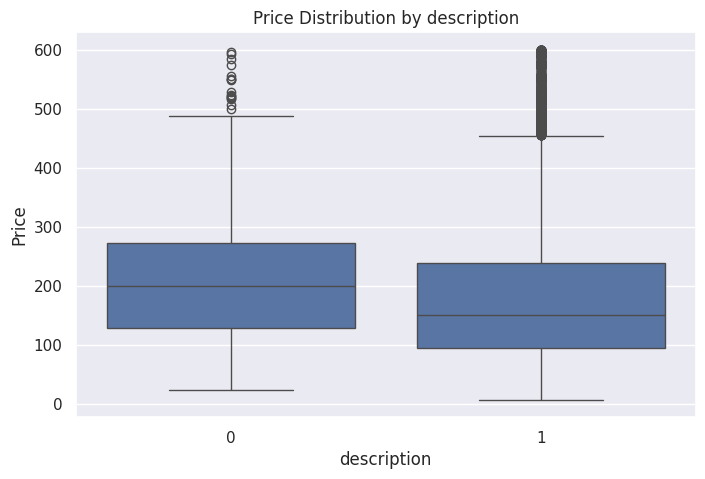

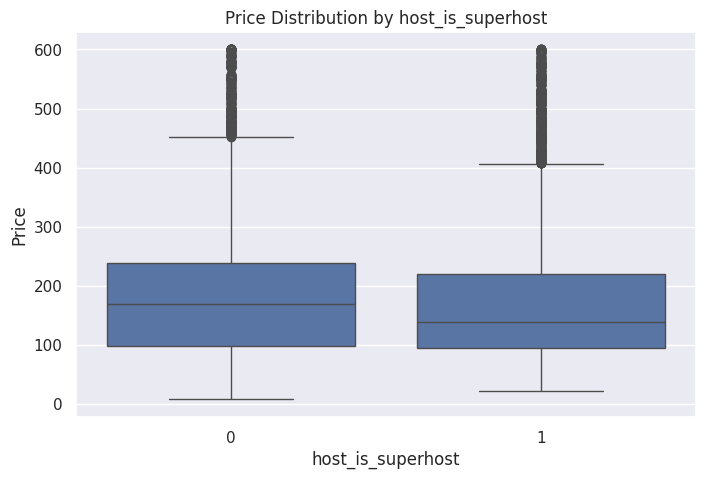

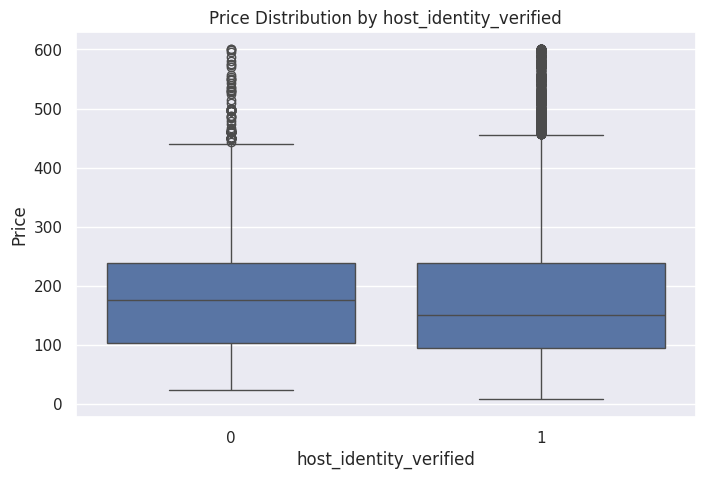

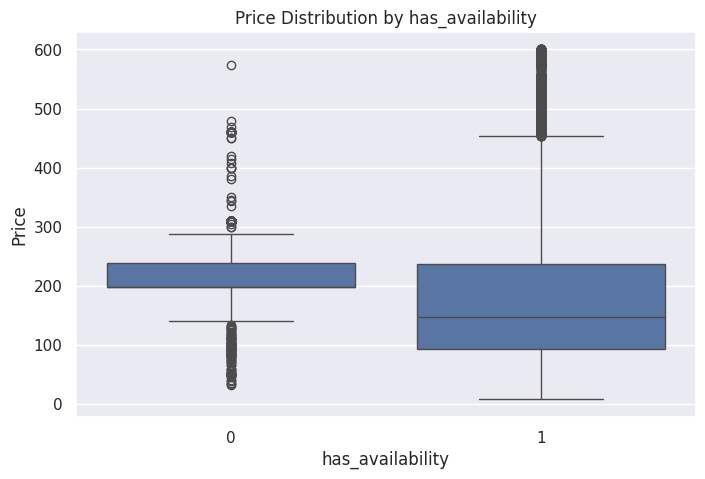

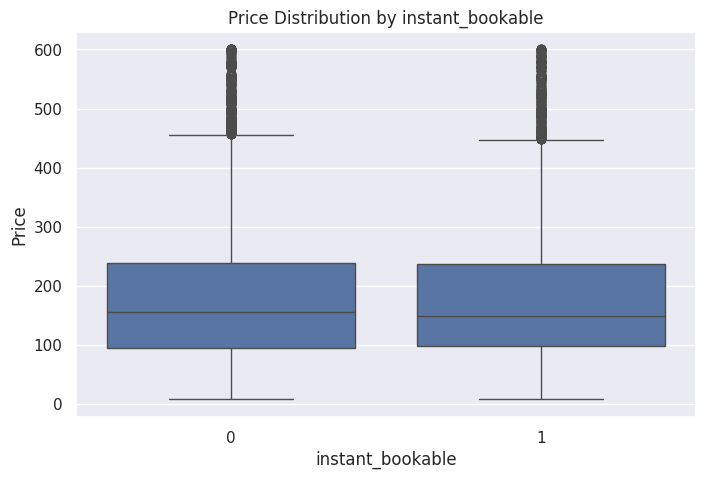

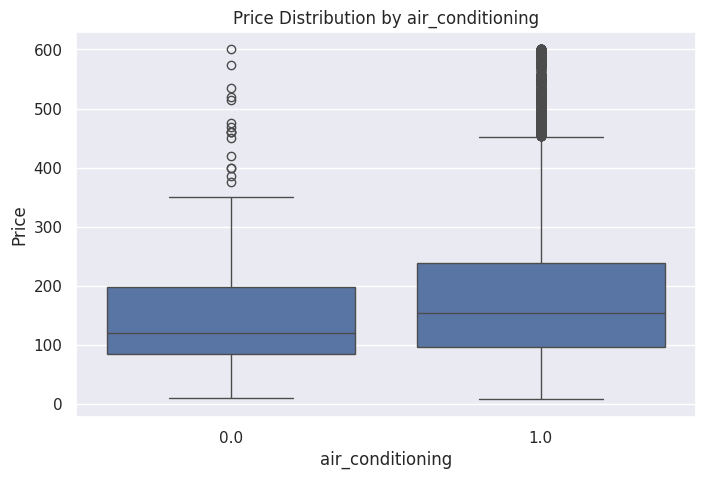

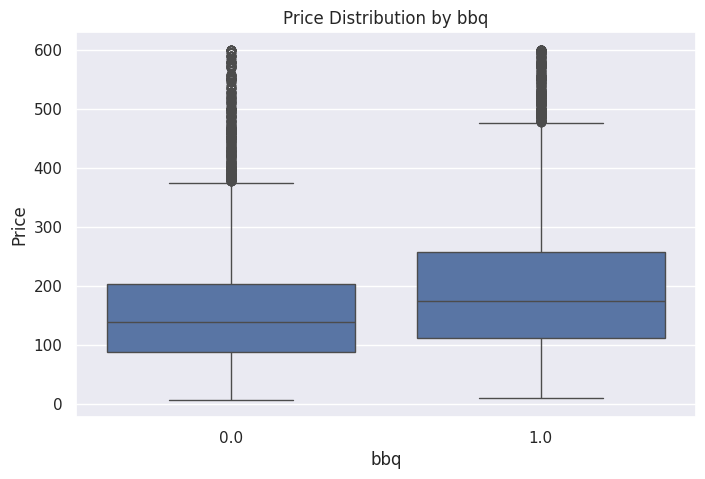

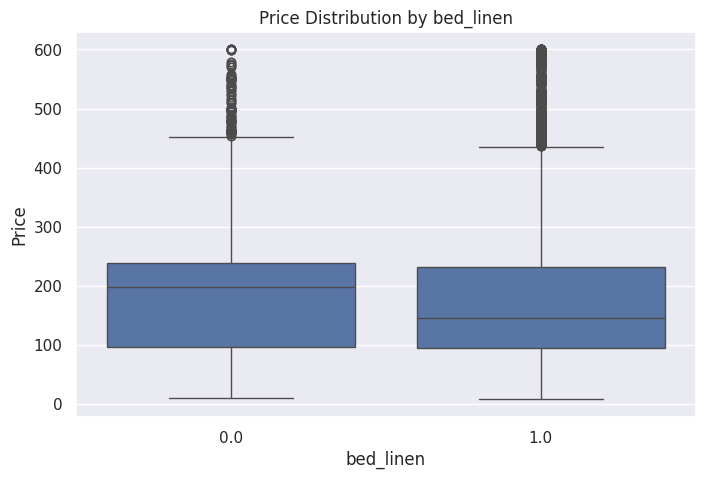

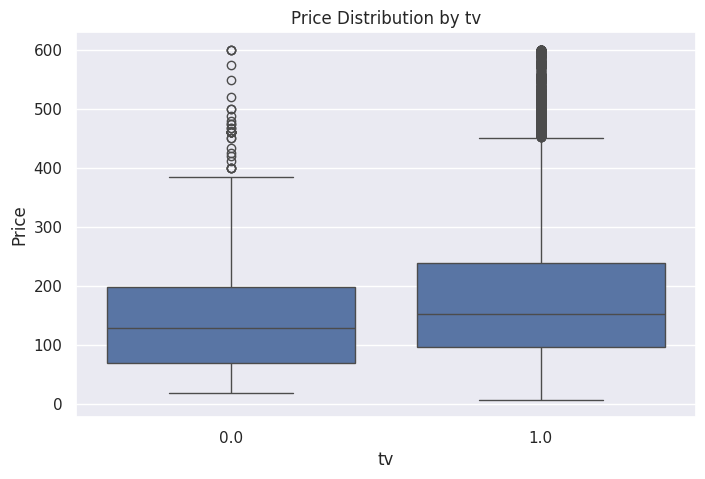

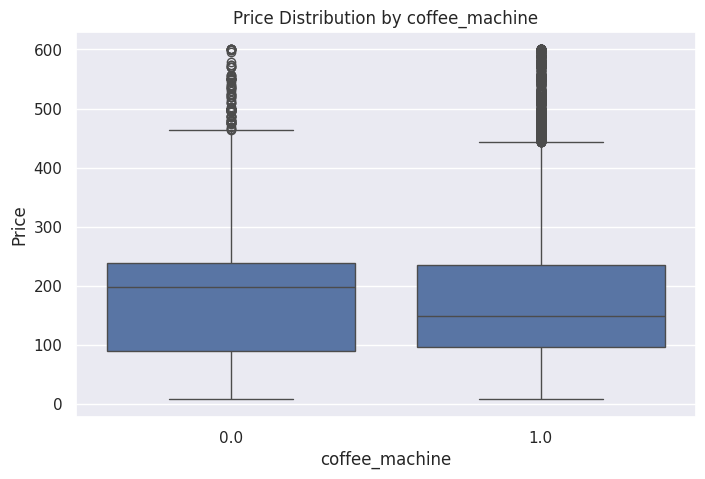

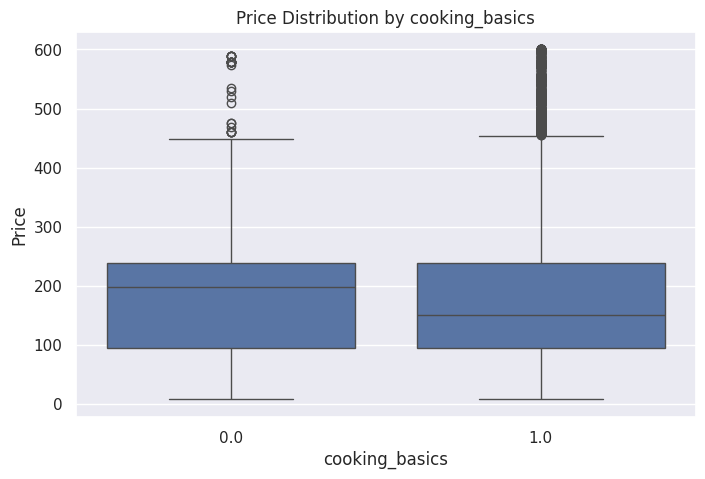

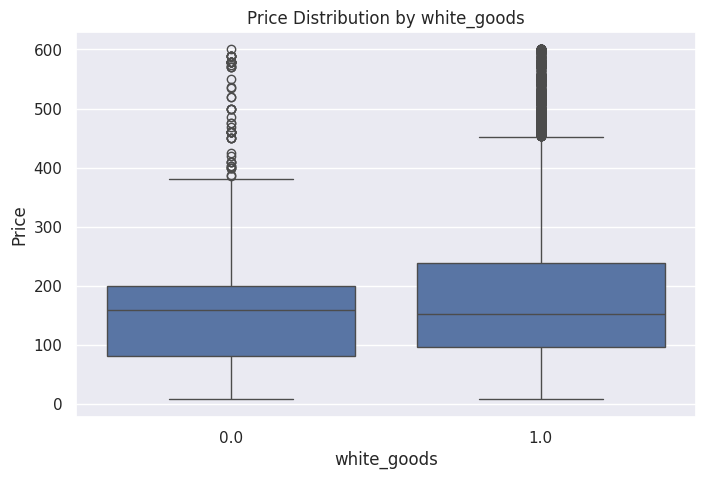

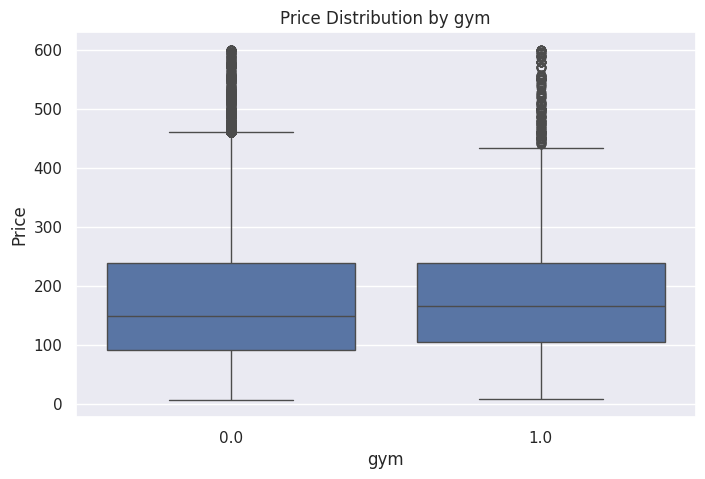

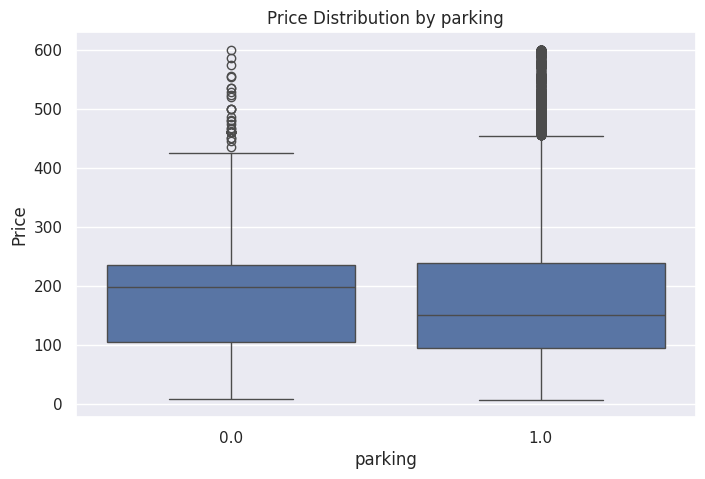

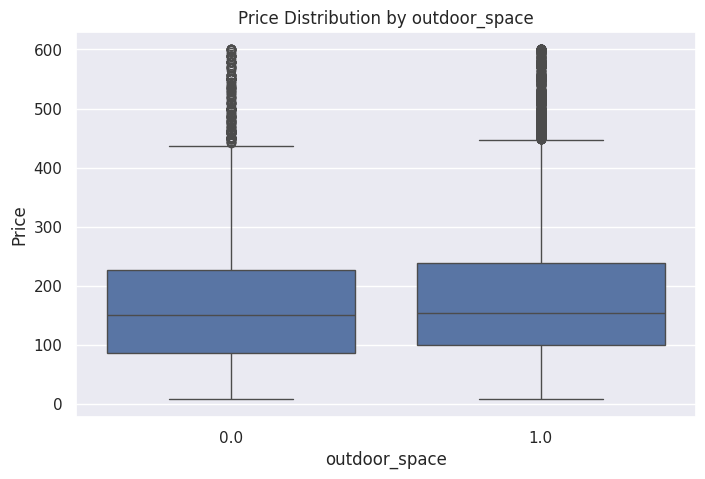

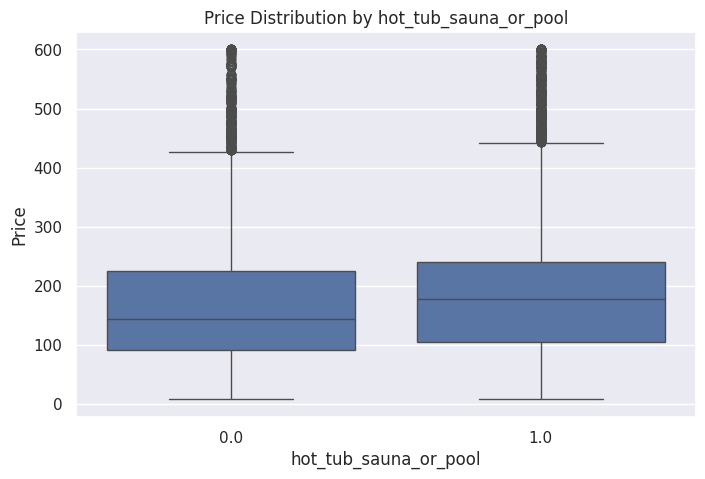

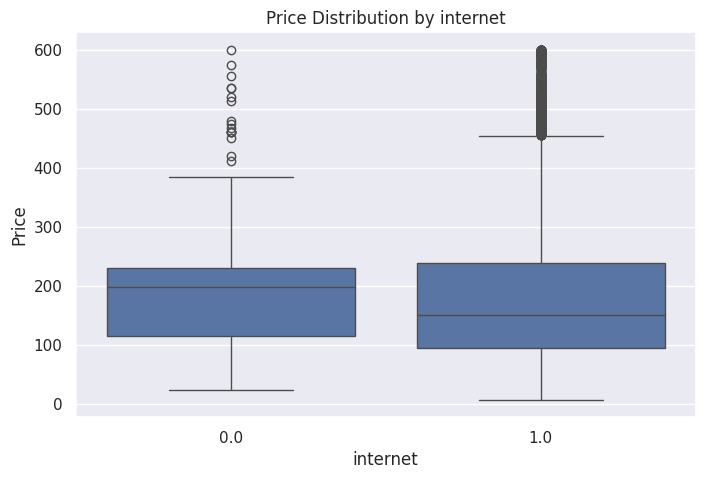

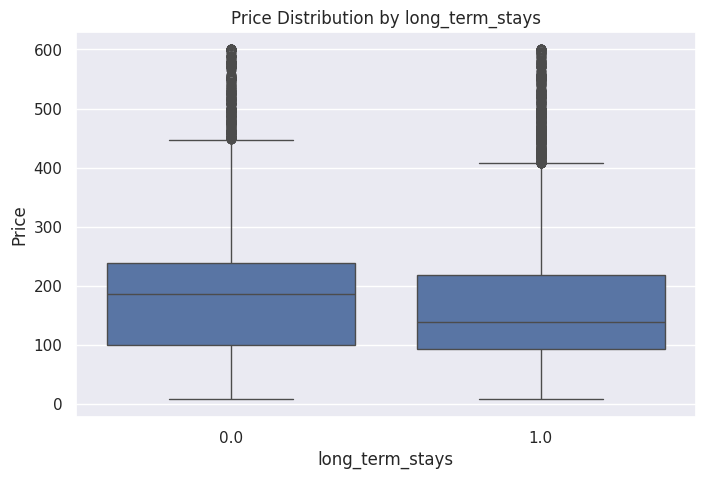

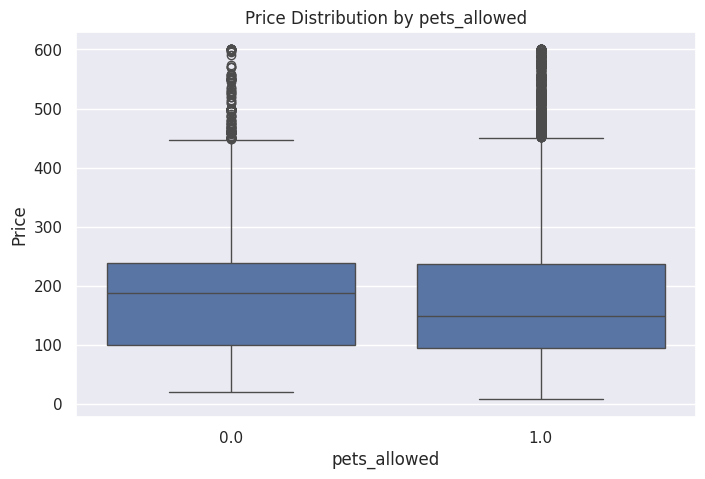

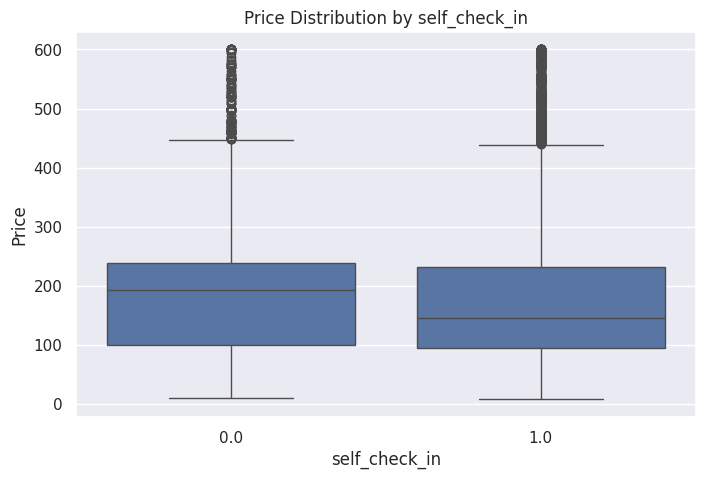

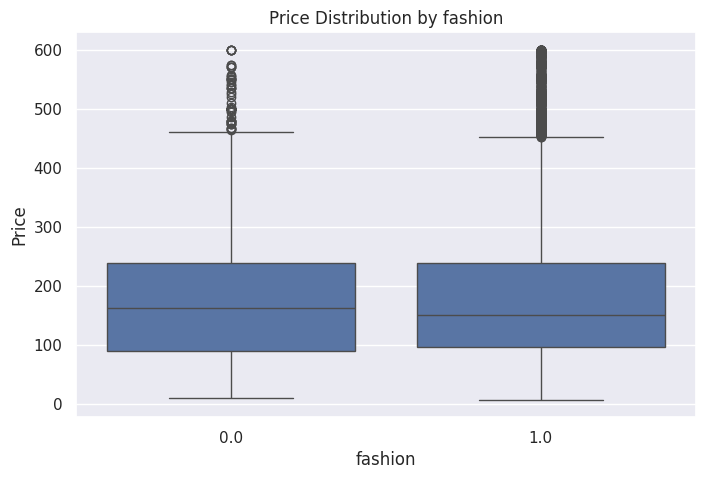

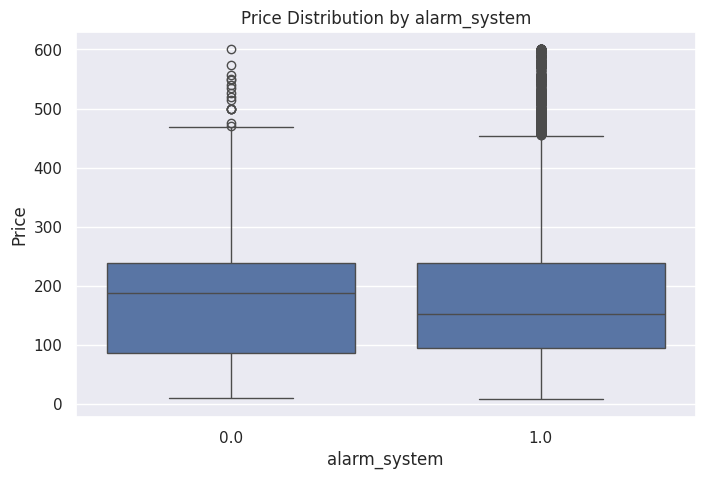

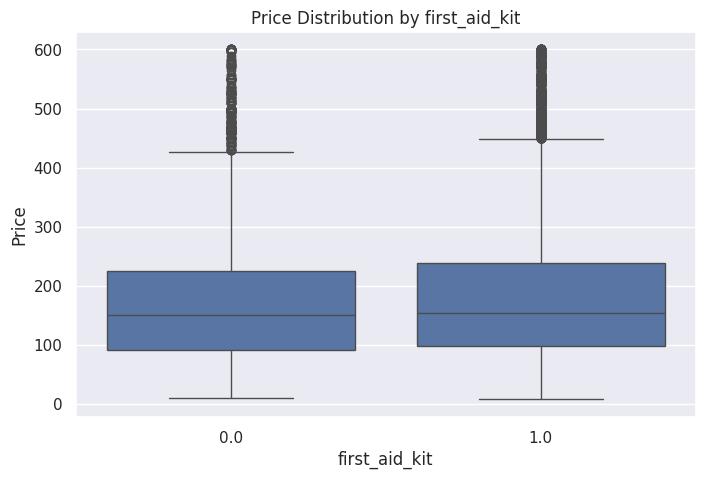

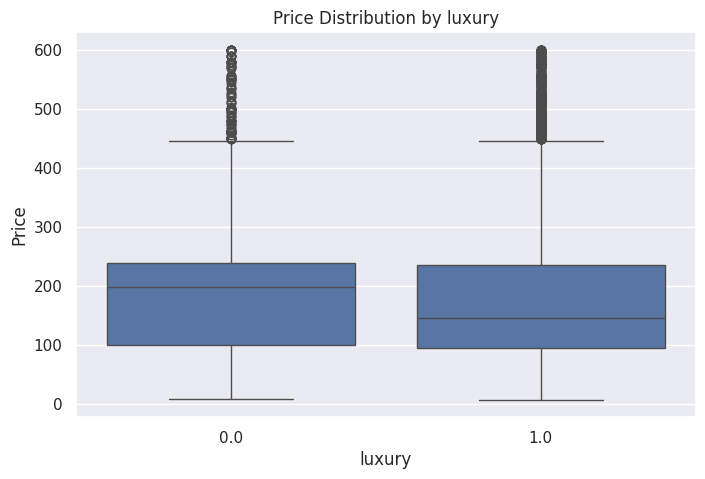

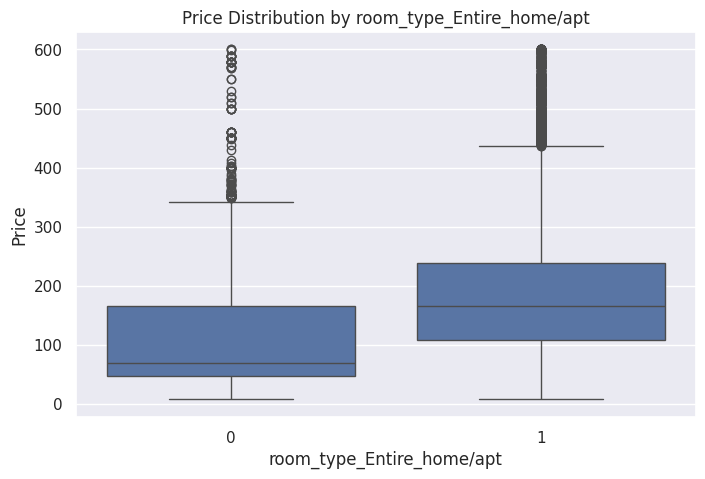

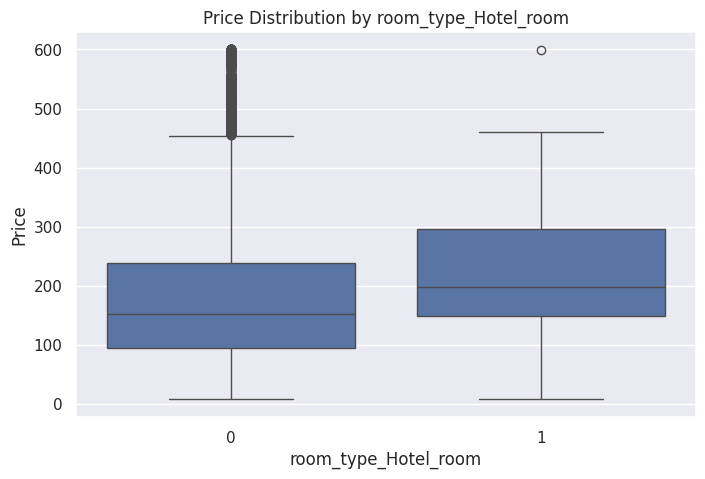

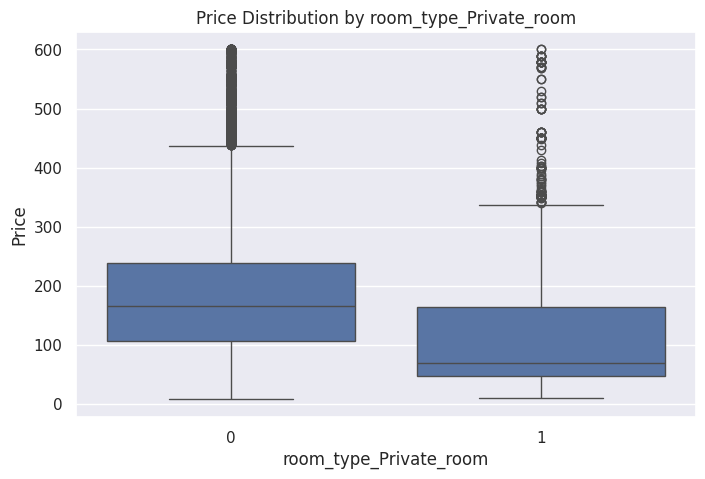

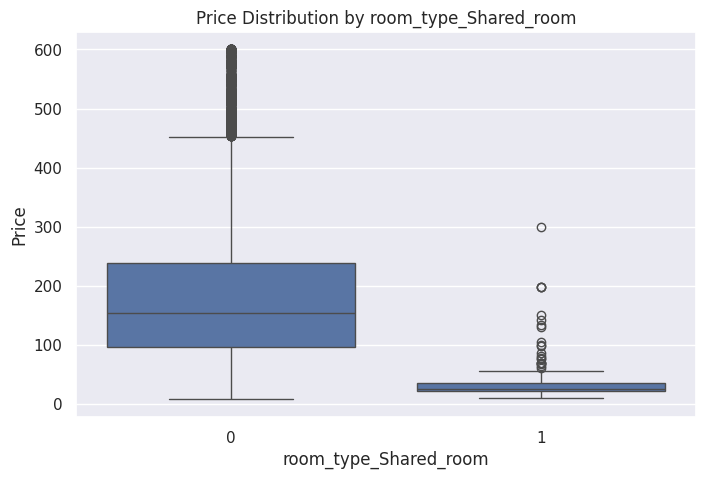

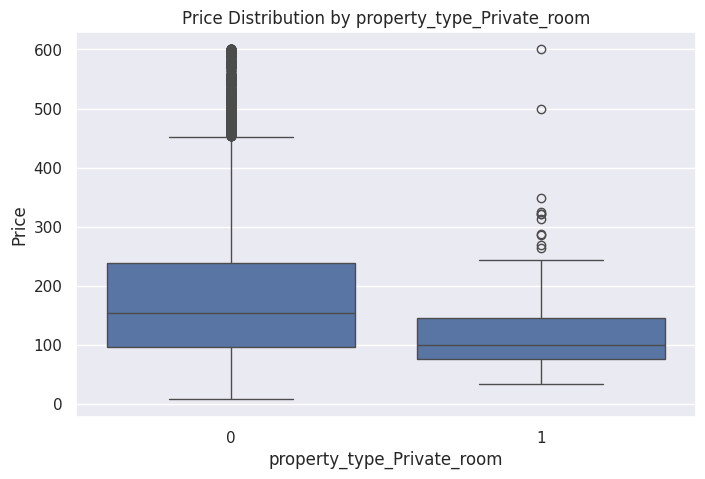

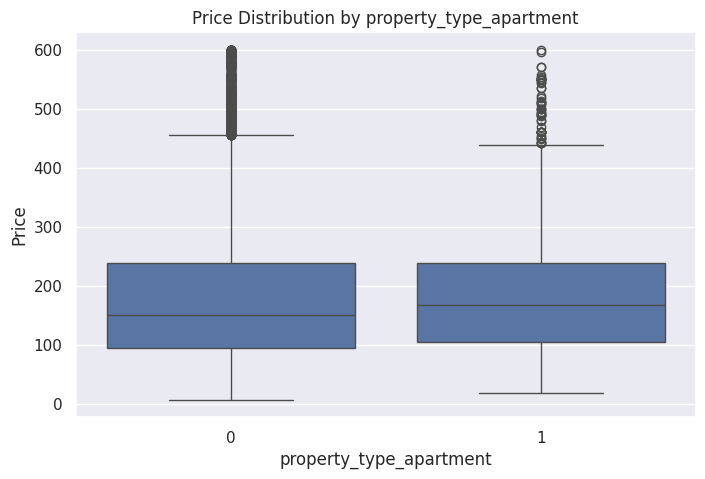

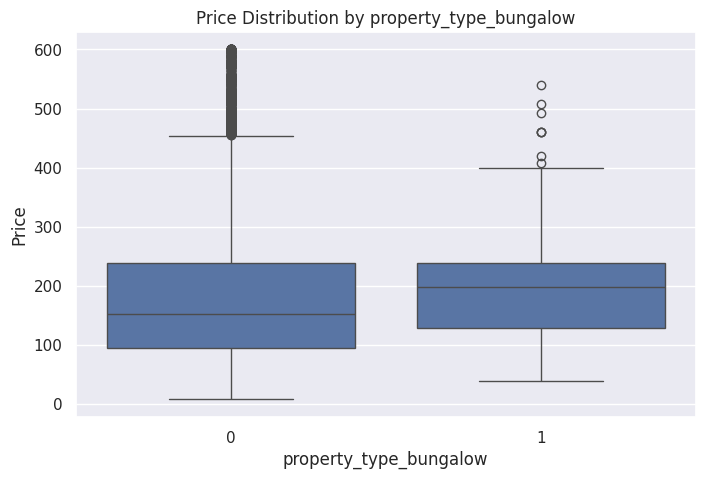

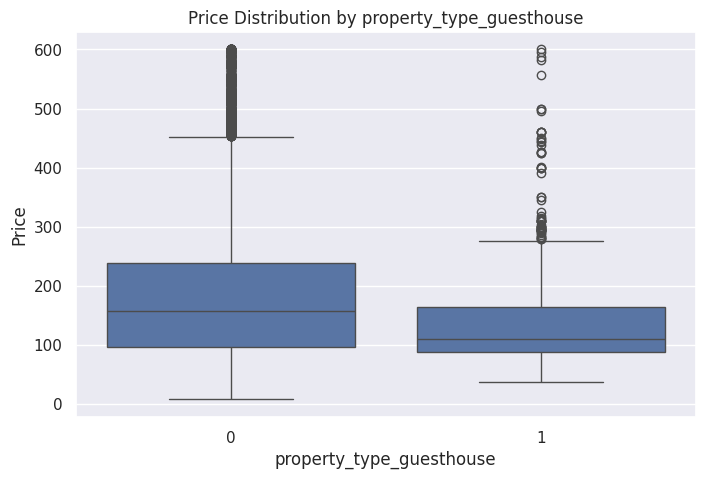

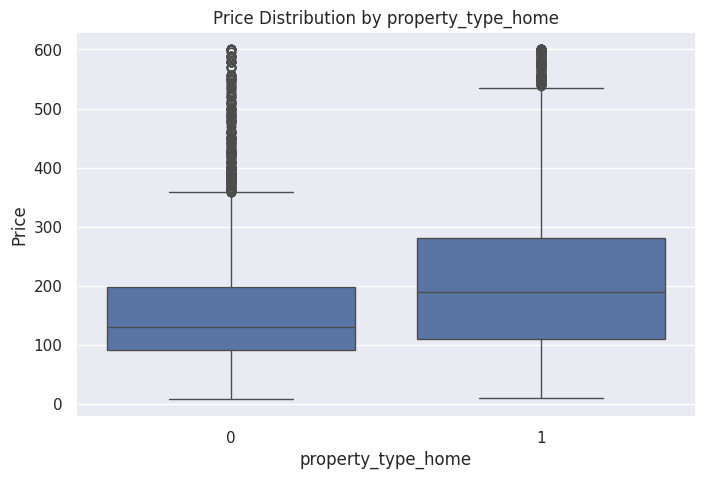

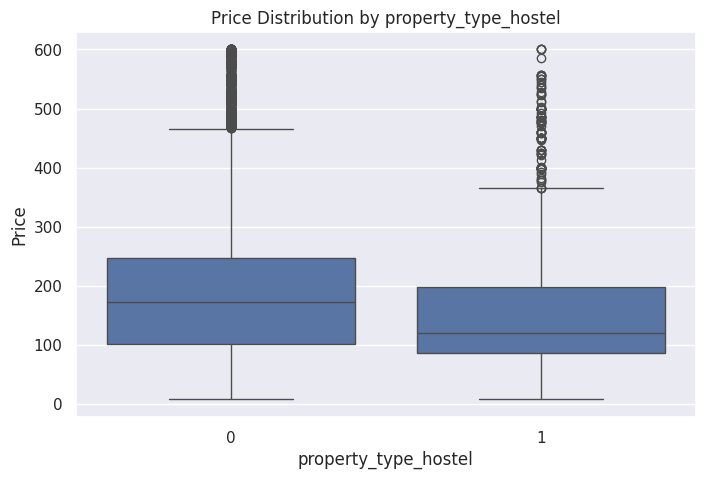

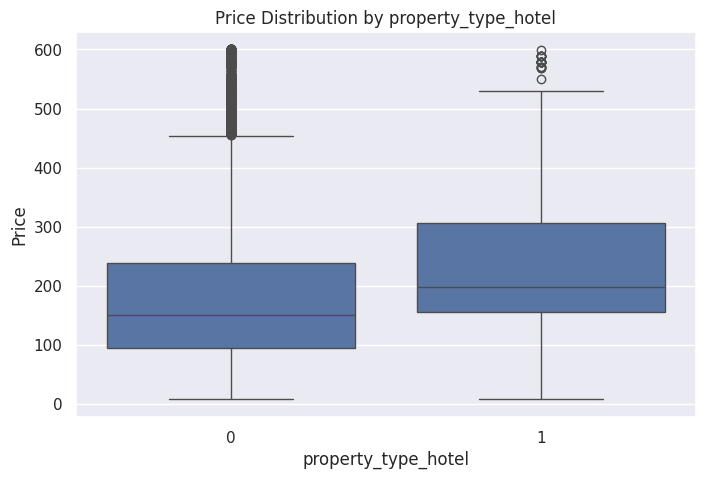

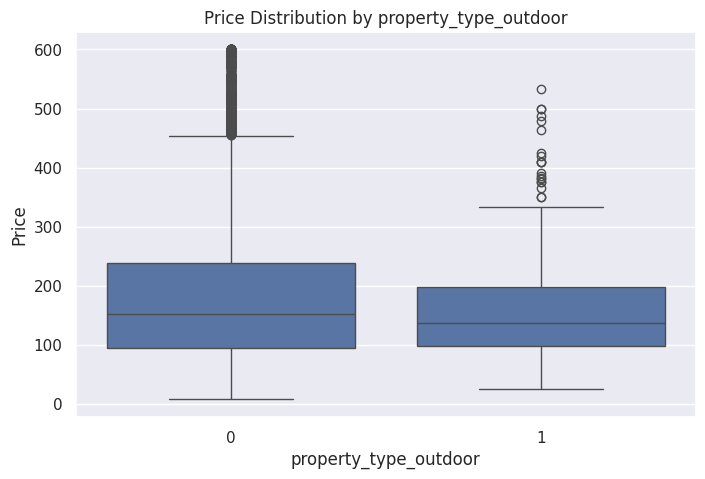

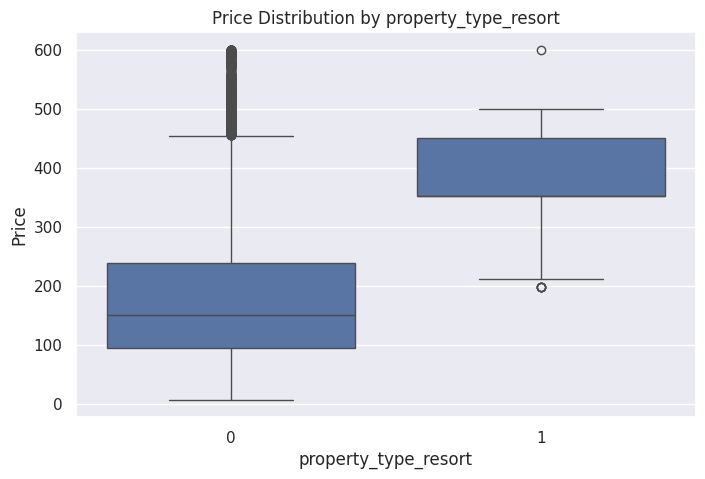

In [ ]:
# Extract binary columns from the dataset (non-interval columns that are integer type)
binary_columns = [
    col for col in transformedDF.columns
    if col not in interval_cols and transformedDF[col].nunique() == 2
]

# Plot price distribution for each binary column
import matplotlib.pyplot as plt
import seaborn as sb

for binary_col in binary_columns:
    plt.figure(figsize=(8, 5))
    sb.boxplot(x=transformedDF[binary_col], y=transformedDF['price'])
    plt.title(f'Price Distribution by {binary_col}')
    plt.xlabel(binary_col)
    plt.ylabel('Price')
    plt.show()


#Model 1: Linear Regression without log transformation

In [ ]:
# Creating and fitting the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ["Predictors", "Coefficients"]))
print()

Intercept of Regression 	: b =  241424429341414.16

                    Predictors  Coefficients
0                  description -2.197084e+01
1         host_acceptance_rate -1.136178e+00
2            host_is_superhost -1.092844e+01
3    host_total_listings_count  6.802128e+01
4       host_identity_verified -4.890791e-01
5                 accommodates  7.955682e+01
6                    bathrooms  2.341405e+02
7                     bedrooms  2.287969e+02
8                         beds  6.668992e+01
9               minimum_nights -2.662838e+02
10              maximum_nights -5.083152e+00
11            has_availability -2.481499e+01
12           number_of_reviews  1.868498e+01
13        review_scores_rating  1.103880e+02
14            instant_bookable -1.708462e+00
15           reviews_per_month -1.578679e+02
16          host_duration_days  2.044459e+01
17       availability_30_ratio  8.388847e+00
18       availability_60_ratio  1.008855e+02
19       availability_90_ratio -1.271516e+02
20 

In [ ]:
# Predict Response corresponding to Predictors
testPredictionLR = linreg.predict(X_test)

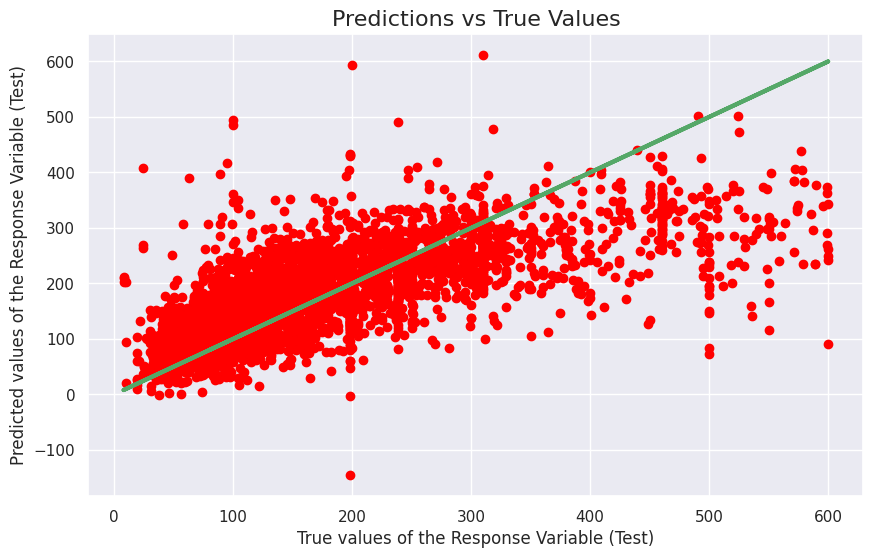

In [ ]:
# Plot the Predictions vs the True values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, testPredictionLR, color = "red")
plt.plot(y_test, y_test, 'g-', linewidth = 3)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Predictions vs True Values", fontsize=16)

# Display the plot
plt.show()

#accuracy = 51

In [ ]:
import statsmodels.api as sm

# Add a constant for the intercept in the model
X_train_const = sm.add_constant(X_train)

# Fit the linear regression model using statsmodels
linreg_sm = sm.OLS(y_train, X_train_const).fit()

# Print the summary of the linear regression model
linreg_sm_summary = linreg_sm.summary()
print(linreg_sm_summary)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     330.9
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:19:29   Log-Likelihood:                -91374.
No. Observations:               15853   AIC:                         1.829e+05
Df Residuals:                   15801   BIC:                         1.833e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
p_values = linreg_sm.pvalues
significance_level = 0.05
significant_vars = p_values[p_values < significance_level].index
# Print significant variables
print("Significant variables:")
print(significant_vars)
print(p_values)

Significant variables:
Index(['const', 'description', 'host_is_superhost',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'minimum_nights', 'has_availability', 'review_scores_rating',
       'reviews_per_month', 'host_duration_days', 'availability_60_ratio',
       'availability_90_ratio', 'amenities_count', 'air_conditioning', 'bbq',
       'bed_linen', 'coffee_machine', 'cooking_basics', 'gym',
       'hot_tub_sauna_or_pool', 'long_term_stays', 'pets_allowed',
       'self_check_in', 'fashion', 'luxury', 'room_type_Entire_home/apt',
       'room_type_Hotel_room', 'room_type_Private_room',
       'room_type_Shared_room', 'property_type_Private_room',
       'property_type_apartment', 'property_type_bungalow',
       'property_type_guesthouse', 'property_type_home',
       'property_type_hostel', 'property_type_hotel', 'property_type_outdoor',
       'property_type_resort'],
      dtype='object')
const                          2.300768e-03
d

In [ ]:
# prompt: what is the p values for all coefficients

import statsmodels.api as sm

# Add a constant to the predictor variables for the intercept term
X_train_with_constant = sm.add_constant(X_train)

# Fit the OLS model
model = sm.OLS(y_train, X_train_with_constant).fit()

# Print the summary of the model, which includes p-values
print(model.summary())

# You can also access the p-values directly from the model results:
p_values = model.pvalues

# Print p-values for each coefficient
print("P-values for coefficients:")
for predictor, p_value in p_values.items():
    print(f"{predictor}: {p_value}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     330.9
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:19:32   Log-Likelihood:                -91374.
No. Observations:               15853   AIC:                         1.829e+05
Df Residuals:                   15801   BIC:                         1.833e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
# prompt: list the columns with p value less than 0.05 and greater than 0.05

# Assuming 'model' is your fitted OLS model from statsmodels
p_values = model.pvalues

# Create lists to store columns with p-values less than and greater than 0.05
cols_p_less_005 = []
cols_p_greater_005 = []

# Iterate through p-values and add columns to corresponding lists
for predictor, p_value in p_values.items():
    if p_value < 0.05:
        cols_p_less_005.append(predictor)
    else:
        cols_p_greater_005.append(predictor)

print("Columns with p-value < 0.05:")
print(cols_p_less_005)
print("\nColumns with p-value > 0.05:")
cols_p_greater_005

Columns with p-value < 0.05:
['const', 'description', 'host_is_superhost', 'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'has_availability', 'review_scores_rating', 'reviews_per_month', 'host_duration_days', 'availability_60_ratio', 'availability_90_ratio', 'amenities_count', 'air_conditioning', 'bbq', 'bed_linen', 'coffee_machine', 'cooking_basics', 'gym', 'hot_tub_sauna_or_pool', 'long_term_stays', 'pets_allowed', 'self_check_in', 'fashion', 'luxury', 'room_type_Entire_home/apt', 'room_type_Hotel_room', 'room_type_Private_room', 'room_type_Shared_room', 'property_type_Private_room', 'property_type_apartment', 'property_type_bungalow', 'property_type_guesthouse', 'property_type_home', 'property_type_hostel', 'property_type_hotel', 'property_type_outdoor', 'property_type_resort']

Columns with p-value > 0.05:


['host_acceptance_rate',
 'host_identity_verified',
 'maximum_nights',
 'number_of_reviews',
 'instant_bookable',
 'availability_30_ratio',
 'tv',
 'white_goods',
 'parking',
 'outdoor_space',
 'internet',
 'alarm_system',
 'first_aid_kit']

# Model 2: stepwise regression having columns p value less than 0.05

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

initial_features = []  # Start with no features
remaining_features = list(X_train.columns)  # All features are candidates
selected_features = []  # Final selected features
p_threshold = 0.05  # Significance level for adding/removing features

# Step 4: Forward selection
while remaining_features:
    p_values = {}
    for feature in remaining_features:
        # Test the model with the current feature
        model = sm.OLS(y_train, sm.add_constant(X_train[initial_features + [feature]])).fit()
        p_values[feature] = model.pvalues[feature]

    # Select the feature with the lowest p-value
    best_feature = min(p_values, key=p_values.get)

    if p_values[best_feature] < p_threshold:
        # Add the best feature to the model
        initial_features.append(best_feature)
        remaining_features.remove(best_feature)
        selected_features.append(best_feature)
    else:
        break  # Stop if no features meet the threshold

# Step 5: Backward elimination (optional)
# Remove features iteratively that are no longer significant
for feature in selected_features.copy():
    model = sm.OLS(y_train, sm.add_constant(X_train[selected_features])).fit()
    if model.pvalues[feature] > p_threshold:
        selected_features.remove(feature)

# Final selected features
print("Final selected features for linear regression:", selected_features)


Final selected features for linear regression: ['accommodates', 'bathrooms', 'reviews_per_month', 'long_term_stays', 'availability_90_ratio', 'availability_60_ratio', 'property_type_resort', 'room_type_Entire_home/apt', 'property_type_hotel', 'bedrooms', 'hot_tub_sauna_or_pool', 'property_type_hostel', 'has_availability', 'review_scores_rating', 'minimum_nights', 'bbq', 'self_check_in', 'host_duration_days', 'host_is_superhost', 'luxury', 'amenities_count', 'pets_allowed', 'description', 'host_total_listings_count', 'room_type_Private_room', 'coffee_machine', 'beds', 'bed_linen', 'gym', 'property_type_Private_room', 'cooking_basics', 'air_conditioning', 'property_type_apartment', 'fashion']


#summary of stepwise model
accuracy = 51

In [ ]:
# Print the summary of the final model with selected features
final_model = sm.OLS(y_train, sm.add_constant(X_train[selected_features])).fit()

# Display the model summary
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     495.6
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:21:58   Log-Likelihood:                -91384.
No. Observations:               15853   AIC:                         1.828e+05
Df Residuals:                   15818   BIC:                         1.831e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

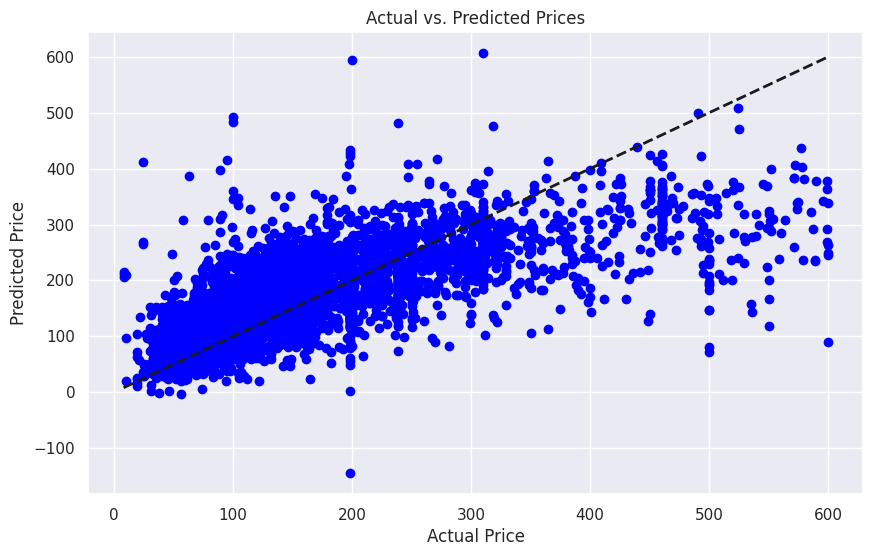

In [ ]:

y_pred = final_model.predict(sm.add_constant(X_test[selected_features]))

# You can also visualize the comparison using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Add a diagonal line for perfect prediction
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.show()

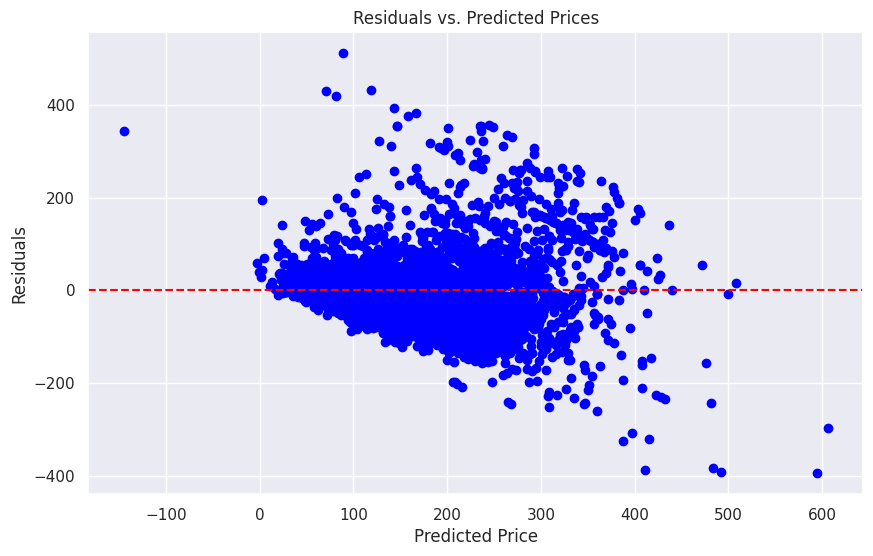

In [ ]:
# prompt: residuals vs predicted

# Calculate residuals
residuals = y_test - y_pred

# Create a scatter plot of residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Prices')
plt.show()

<Figure size 1000x600 with 0 Axes>

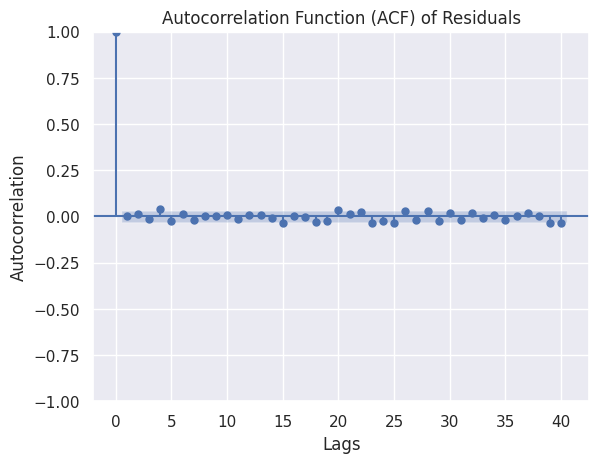

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


# Plot the ACF graph of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40, alpha=0.05)  # 40 lags, 95% confidence interval
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

#log transformation

In [ ]:
ScaledDF2=ScaledDF.copy()
ScaledDF2['price_log'] = np.log(ScaledDF2['price'])
# Separating X and y for Modelling
X_1 = ScaledDF2.drop('price', axis=1)
X_1 = X_1.drop('price_log', axis=1)
y_1 = ScaledDF2['price_log']


In [ ]:
'''interval_cols = ['host_acceptance_rate','host_total_listings_count','accommodates',
                 'bathrooms', 'bedrooms', 'beds', 'minimum_nights','maximum_nights','number_of_reviews',
                 'review_scores_rating','reviews_per_month','host_duration_days',
                 'availability_30_ratio', 'availability_60_ratio','availability_90_ratio',
                 'amenities_count',]

# Scale the interval features
scaler = MinMaxScaler()
X_1[interval_cols] = scaler.fit_transform(X_1[interval_cols])'''


"interval_cols = ['host_acceptance_rate','host_total_listings_count','accommodates',\n                 'bathrooms', 'bedrooms', 'beds', 'minimum_nights','maximum_nights','number_of_reviews',\n                 'review_scores_rating','reviews_per_month','host_duration_days',\n                 'availability_30_ratio', 'availability_60_ratio','availability_90_ratio',\n                 'amenities_count',]\n\n# Scale the interval features\nscaler = MinMaxScaler()\nX_1[interval_cols] = scaler.fit_transform(X_1[interval_cols])"

In [ ]:
# prompt: covert y_1 to dataframe

y_1 = pd.DataFrame(y_1)

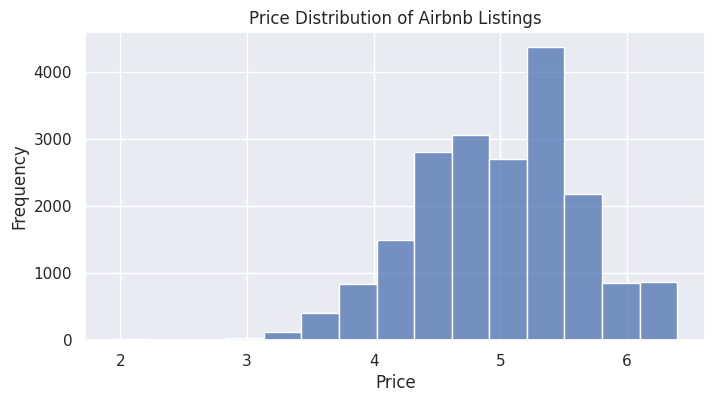

In [ ]:
plt.figure(figsize=(8, 4))
sb.histplot(y_1['price_log'], bins=15, kde=False)
plt.title('Price Distribution of Airbnb Listings')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Splitting into train and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.2)

#log model summary 0.562

In [ ]:
log_model = sm.OLS(y_train1, sm.add_constant(X_train1[selected_features])).fit()

# Display the model summary
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     588.2
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:22:00   Log-Likelihood:                -9027.5
No. Observations:               15853   AIC:                         1.813e+04
Df Residuals:                   15818   BIC:                         1.839e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

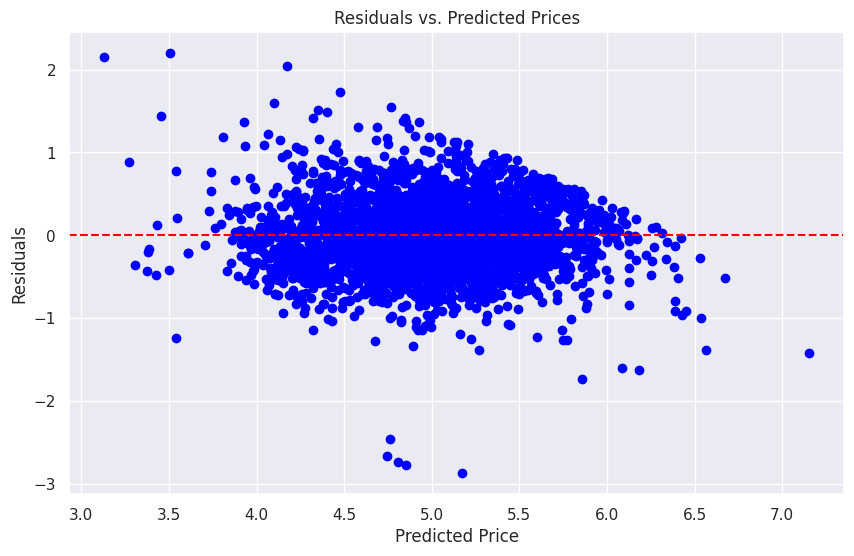

In [ ]:
# prompt: residuals vs predicted
y_pred1 = log_model.predict(sm.add_constant(X_test1[selected_features]))
# Calculate residuals
residuals1 = y_test1['price_log'] - y_pred1

# Create a scatter plot of residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred1, residuals1, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Prices')
plt.show()

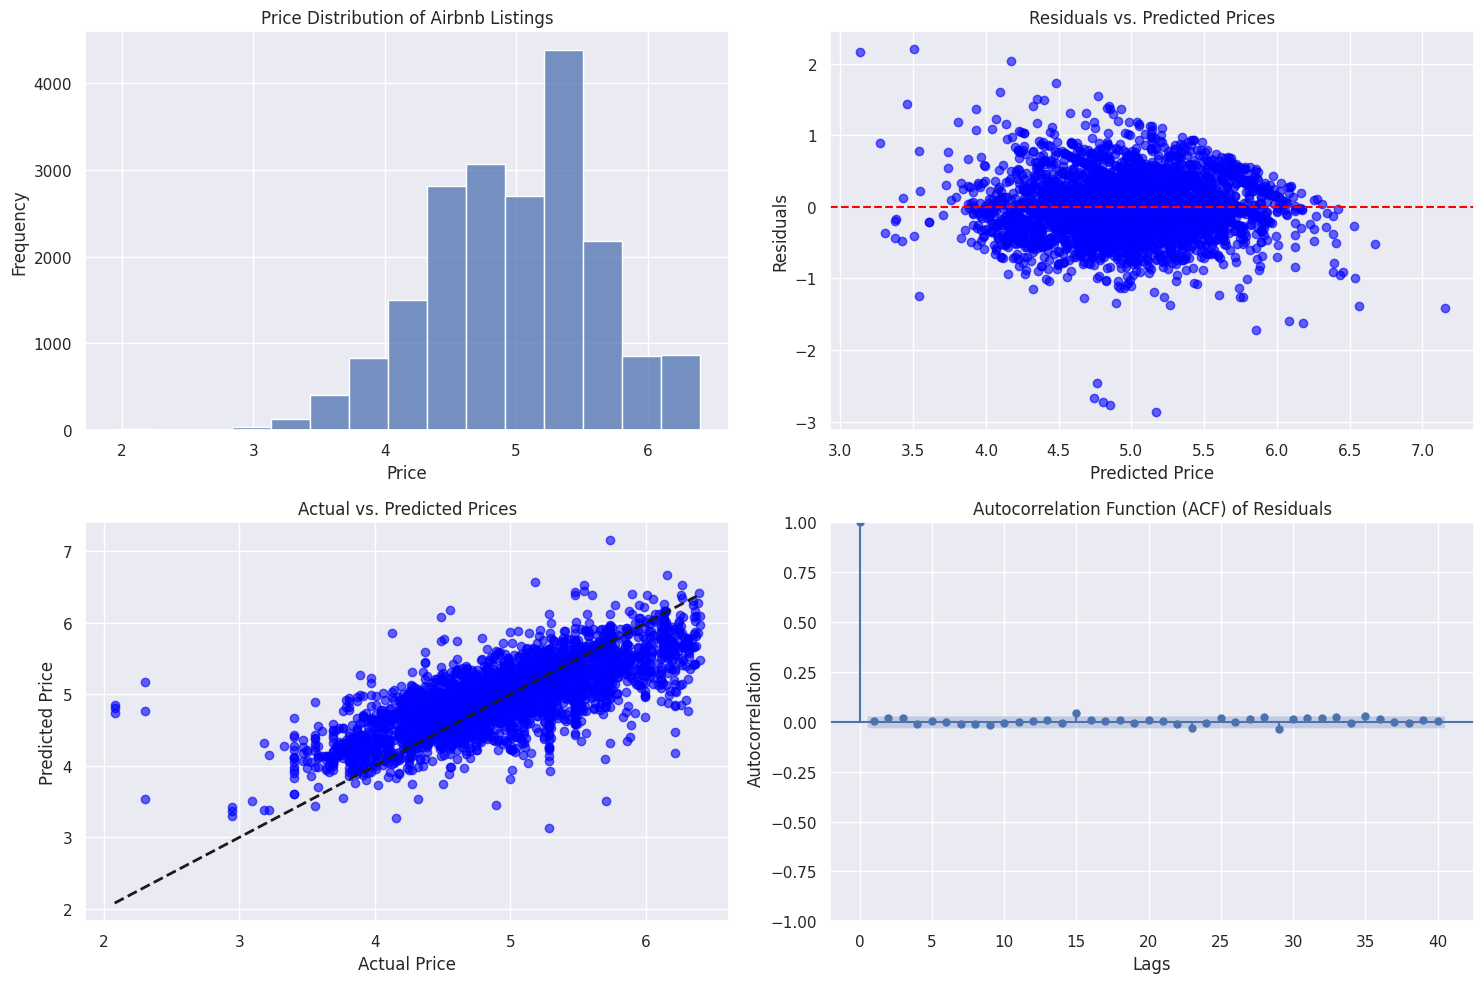

In [ ]:
# Create a single plot with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 1. Price Distribution
sb.histplot(y_1['price_log'], bins=15, kde=False, ax=axs[0, 0])
axs[0, 0].set_title('Price Distribution of Airbnb Listings')
axs[0, 0].set_xlabel('Price')
axs[0, 0].set_ylabel('Frequency')

# 2. Residuals vs Predicted
axs[0, 1].scatter(y_pred1, y_test1['price_log'] - y_pred1, color='blue', alpha=0.6)
axs[0, 1].axhline(y=0, color='red', linestyle='--')
axs[0, 1].set_title('Residuals vs. Predicted Prices')
axs[0, 1].set_xlabel('Predicted Price')
axs[0, 1].set_ylabel('Residuals')

# 3. Actual vs Predicted Prices
axs[1, 0].scatter(y_test1, y_pred1, color='blue', alpha=0.6)
axs[1, 0].plot([y_test1.min(), y_test1.max()], [y_test1.min(), y_test1.max()], 'k--', lw=2)
axs[1, 0].set_title('Actual vs. Predicted Prices')
axs[1, 0].set_xlabel('Actual Price')
axs[1, 0].set_ylabel('Predicted Price')

# 4. ACF Plot of Residuals
plot_acf(residuals1, lags=40, alpha=0.05, ax=axs[1, 1])
axs[1, 1].set_title('Autocorrelation Function (ACF) of Residuals')
axs[1, 1].set_xlabel('Lags')
axs[1, 1].set_ylabel('Autocorrelation')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#Model 2:  Random Forest Regression 0.55

In [ ]:
# Separating X and y for Modelling
X = transformedDF.drop('price', axis=1)
y = transformedDF['price']
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Creating and fitting the model
RF = RandomForestRegressor(n_estimators=2000, max_depth=100,min_samples_split = 5, min_samples_leaf = 10,
                           max_leaf_nodes = 70,max_features = 'sqrt').fit(X_train,y_train)

# Predicting the training and testing sets
trainPredictin_RF = RF.predict(X_train)
testPredictin_RF =RF.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, trainPredictin_RF)
test_r2 = r2_score(y_test, testPredictin_RF)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

# Calculate RMSE
train_rmse = mean_squared_error(y_train, trainPredictin_RF, squared=False)
test_rmse = mean_squared_error(y_test, testPredictin_RF, squared=False)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train R^2: 0.5844937148207292
Test R^2: 0.5595185553629369
Train RMSE: 71.1133173088792
Test RMSE: 75.9129451673905


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
importancesRF = RF.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train.columns)
feat_imp1.sort_values('Weight', ascending = False ,inplace=True)
feat_imp1

,Weight
bedrooms,0.188680
bathrooms,0.165135
accommodates,0.142281
beds,0.110137
availability_90_ratio,0.049215
room_type_Entire_home/apt,0.032841
availability_60_ratio,0.030257
property_type_home,0.024470
room_type_Private_room,0.023567
reviews_per_month,0.021743


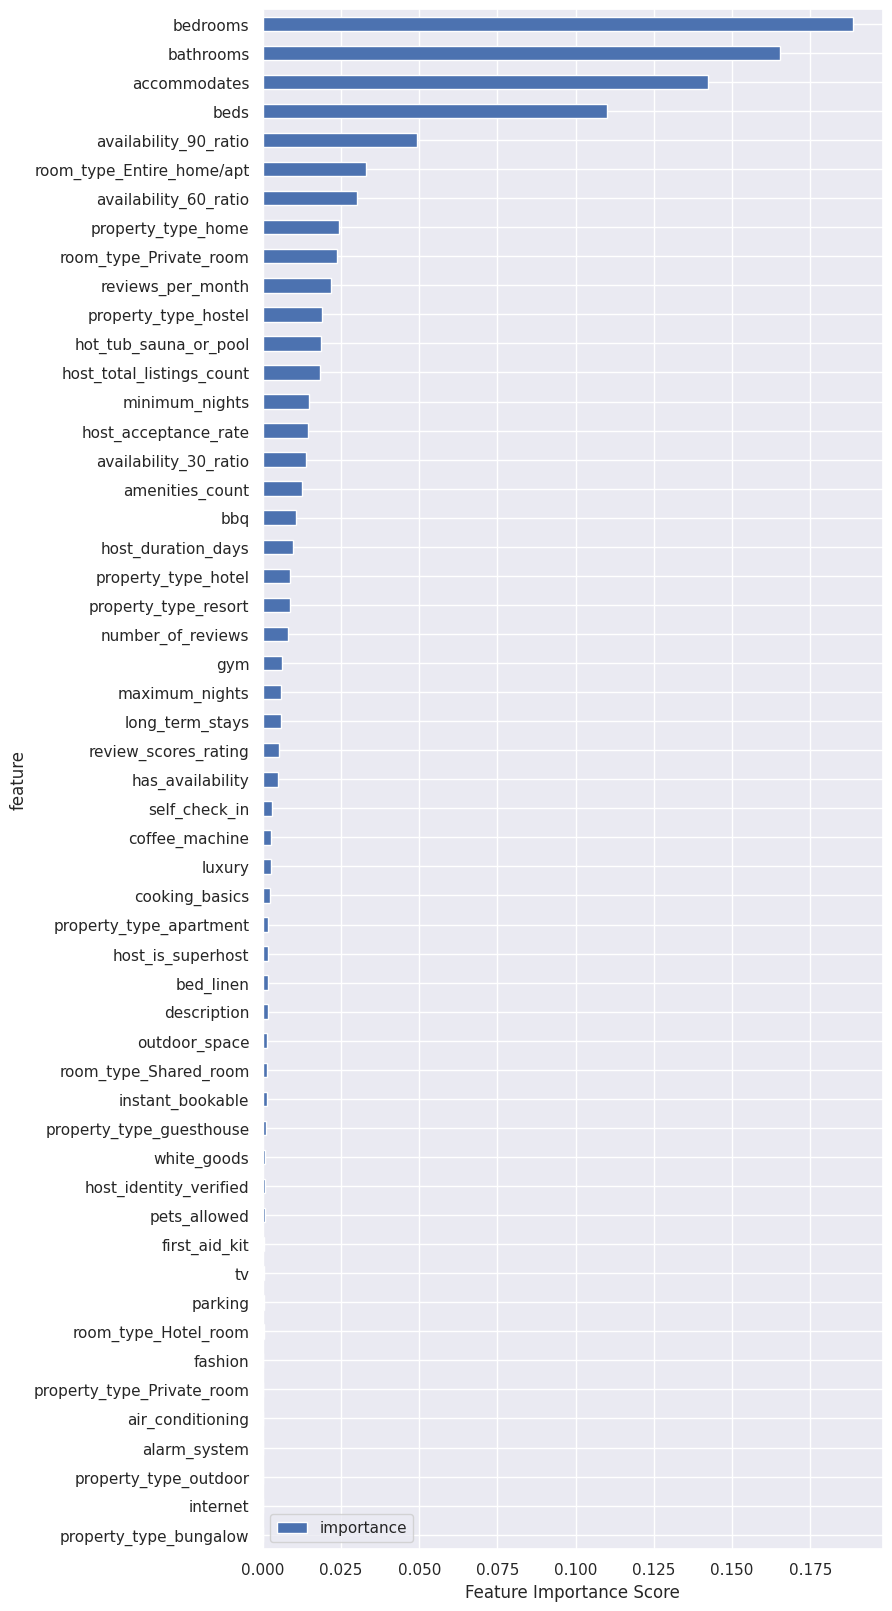

In [ ]:
feat_imp = pd.DataFrame({'importance':RF.feature_importances_})
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(figsize=(8,20))
plt.xlabel('Feature Importance Score')
plt.show()

#RF redused 0.56

In [ ]:
# prompt: remove the least important features and run the random forest again

# Identify less important features (e.g., those with importance < 0.01)
threshold = 0.005
less_important_features = feat_imp[feat_imp['importance'] < threshold].index.tolist()

# Remove the less important features from the dataset
X_train_reduced = X_train.drop(columns=less_important_features)
X_test_reduced = X_test.drop(columns=less_important_features)

# Re-run the Random Forest model with reduced features
RF_reduced = RandomForestRegressor(n_estimators=3000, max_depth=500, min_samples_split=2, min_samples_leaf=5,
                                   max_leaf_nodes=70, max_features='sqrt').fit(X_train_reduced, y_train)


# Predicting the training and testing sets with reduced features
trainPredictin_RF_reduced = RF_reduced.predict(X_train_reduced)
testPredictin_RF_reduced = RF_reduced.predict(X_test_reduced)

# Evaluate the reduced model
train_r2_reduced = r2_score(y_train, trainPredictin_RF_reduced)
test_r2_reduced = r2_score(y_test, testPredictin_RF_reduced)
print(f"Train R^2 (Reduced): {train_r2_reduced}")
print(f"Test R^2 (Reduced): {test_r2_reduced}")

# Calculate RMSE for the reduced model
train_rmse_reduced = mean_squared_error(y_train, trainPredictin_RF_reduced, squared=False)
test_rmse_reduced = mean_squared_error(y_test, testPredictin_RF_reduced, squared=False)
print(f"Train RMSE (Reduced): {train_rmse_reduced}")
print(f"Test RMSE (Reduced): {test_rmse_reduced}")

Train R^2 (Reduced): 0.6001229018456371
Test R^2 (Reduced): 0.5721383687872452
Train RMSE (Reduced): 69.7630413057592
Test RMSE (Reduced): 74.81758797986677


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


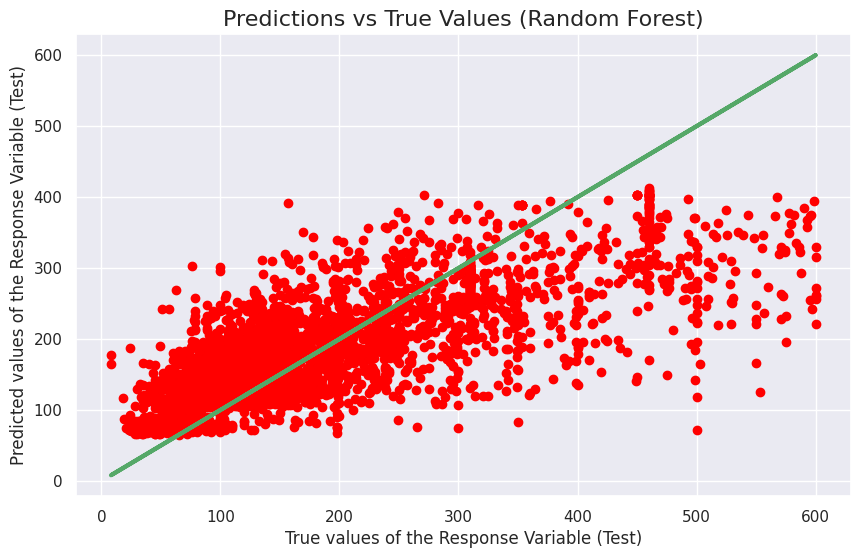

In [ ]:
# prompt: scatter plot prediction vs true value

# Plot the Predictions vs the True values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, testPredictin_RF_reduced, color = "red")
plt.plot(y_test, y_test, 'g-', linewidth = 3)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Predictions vs True Values (Random Forest)", fontsize=16)

# Display the plot
plt.show()

#XGBoost 0.62

In [ ]:
# Fitting and Training the model for Train & Test sets
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 2000)

xgb_reg.fit(X_train,y_train)

# Predicting using the model
trainPredictin_xgb_reg = xgb_reg.predict(X_train)
testPredictin_xgb_reg = xgb_reg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:23:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [ ]:
# prompt: accuracy

# Calculate accuracy metrics for the XGBoost model
train_mse_xgb = mean_squared_error(y_train, trainPredictin_xgb_reg)
train_r2_xgb = r2_score(y_train, trainPredictin_xgb_reg)

test_mse_xgb = mean_squared_error(y_test, testPredictin_xgb_reg, squared= False)
test_r2_xgb = r2_score(y_test, testPredictin_xgb_reg)

# Display the metrics
print("XGBoost Train MSE:", train_mse_xgb)
print("XGBoost Train R2:", train_r2_xgb)
print("XGBoost Test MSE:", test_mse_xgb)
print("XGBoost Test R2:", test_r2_xgb)

XGBoost Train MSE: 1.8241866787548904
XGBoost Train R2: 0.9998501195455838
XGBoost Test MSE: 69.9016663303916
XGBoost Test R2: 0.6265168664613662


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Weightage/Importance of each variable
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending = False, inplace=True)
ft_weights_xgb_reg

,weight
property_type_home,0.105274
bedrooms,0.097598
bathrooms,0.089186
property_type_resort,0.079742
room_type_Entire_home/apt,0.074510
hot_tub_sauna_or_pool,0.063960
property_type_hotel,0.043392
accommodates,0.041008
beds,0.028451
property_type_hostel,0.021930


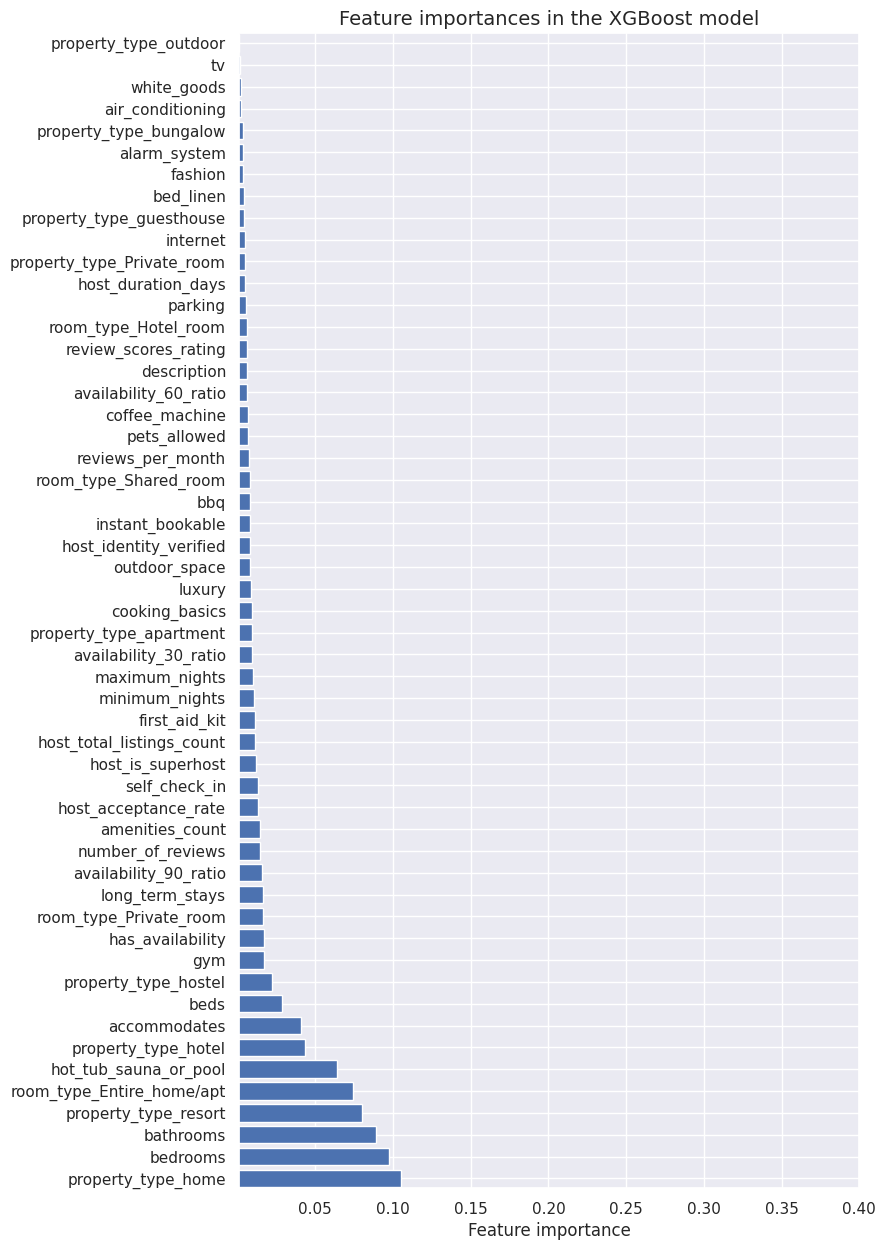

In [ ]:
# Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center')
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.001)
plt.xlim(0.001, 0.4)
plt.show()

#Xgboost reduced 0.65

In [ ]:
# prompt: having a threshold value of 0.001 remove less important variables and run xgboost again

# Identify less important features based on the threshold
threshold = 0.001
less_important_features_xgb = ft_weights_xgb_reg[ft_weights_xgb_reg['weight'] < threshold].index.tolist()

# Remove the less important features from the dataset
X_train_reduced_xgb = X_train.drop(columns=less_important_features_xgb)
X_test_reduced_xgb = X_test.drop(columns=less_important_features_xgb)

# Re-run the XGBoost model with reduced features
xgb_reg_reduced = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.9, learning_rate=0.05,
                                   max_depth=30, alpha=5, n_estimators=2000,subsample=0.8, gamma = 0)
xgb_reg_reduced.fit(X_train_reduced_xgb, y_train)

# Predicting using the reduced model
trainPredictin_xgb_reduced = xgb_reg_reduced.predict(X_train_reduced_xgb)
testPredictin_xgb_reduced = xgb_reg_reduced.predict(X_test_reduced_xgb)

# Calculate accuracy metrics for the reduced XGBoost model
train_mse_xgb_reduced = mean_squared_error(y_train, trainPredictin_xgb_reduced)
train_r2_xgb_reduced = r2_score(y_train, trainPredictin_xgb_reduced)

test_mse_xgb_reduced = mean_squared_error(y_test, testPredictin_xgb_reduced, squared=False)
test_r2_xgb_reduced = r2_score(y_test, testPredictin_xgb_reduced)

# Display the metrics for the reduced model
print("XGBoost Train MSE (Reduced):", train_mse_xgb_reduced)
print("XGBoost Train R2 (Reduced):", train_r2_xgb_reduced)
print("XGBoost Test MSE (Reduced):", test_mse_xgb_reduced)
print("XGBoost Test R2 (Reduced):", test_r2_xgb_reduced)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:23:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBoost Train MSE (Reduced): 1.284352778562119
XGBoost Train R2 (Reduced): 0.9998944738604204
XGBoost Test MSE (Reduced): 66.44879346652009
XGBoost Test R2 (Reduced): 0.6625028296283225


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

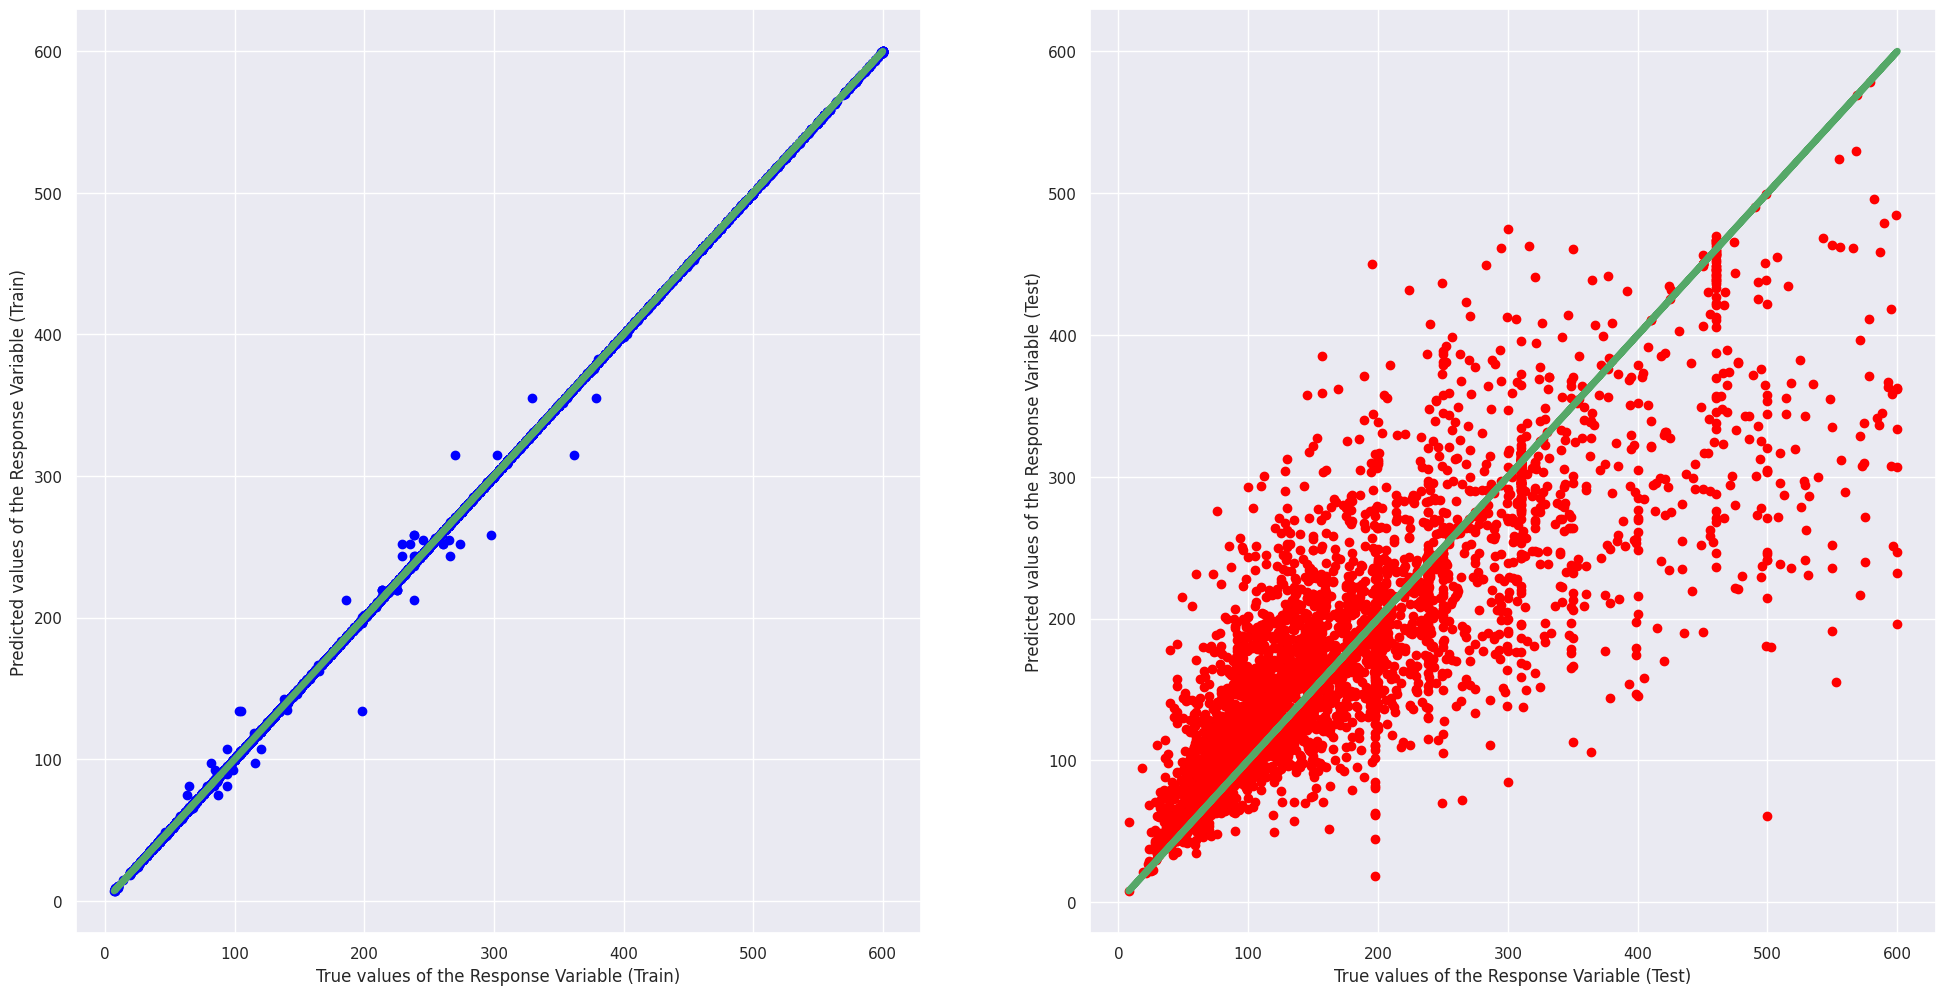

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, trainPredictin_xgb_reduced, color = "blue")
axes[0].plot(y_train, y_train, 'g-', linewidth = 5)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, testPredictin_xgb_reduced, color = "red")
axes[1].plot(y_test, y_test, 'g-', linewidth = 5)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

In [ ]:
# prompt: accuracy

# Calculate accuracy metrics for the XGBoost model
train_mse_xgb = mean_squared_error(y_train, trainPredictin_xgb_reg)
train_r2_xgb = r2_score(y_train, trainPredictin_xgb_reg)

test_mse_xgb = mean_squared_error(y_test, testPredictin_xgb_reg, squared= False)
test_r2_xgb = r2_score(y_test, testPredictin_xgb_reg)

# Display the metrics
print("XGBoost Train MSE:", train_mse_xgb)
print("XGBoost Train R2:", train_r2_xgb)
print("XGBoost Test MSE:", test_mse_xgb)
print("XGBoost Test R2:", test_r2_xgb)

XGBoost Train MSE: 1.8241866787548904
XGBoost Train R2: 0.9998501195455838
XGBoost Test MSE: 69.9016663303916
XGBoost Test R2: 0.6265168664613662


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#Ridge regression

In [ ]:
#numpy array used for plotting Ridge and Lasson Regression later on
varArr = np.array([X_1.columns])
# Ridge Regression
ridge = Ridge(alpha=1)
ridge.fit(X_train1, y_train1)

# Predictions and metrics
y_pred_ridge = ridge.predict(X_test1)

ridge_mse = mean_squared_error(y_test1, y_pred_ridge)
ridge_r2 = r2_score(y_test1, y_pred_ridge)

print(ridge_mse, ridge_r2)

'#numpy array used for plotting Ridge and Lasson Regression later on\nvarArr = np.array([X_1.columns])\n# Ridge Regression\nridge = Ridge(alpha=1)\nridge.fit(X_train1, y_train1)\n\n# Predictions and metrics\ny_pred_ridge = ridge.predict(X_test1)\n\nridge_mse = mean_squared_error(y_test1, y_pred_ridge)\nridge_r2 = r2_score(y_test1, y_pred_ridge)\n\nprint(ridge_mse, ridge_r2)'

In [ ]:
'''import warnings

# Suppress performance warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

#numpy array used for plotting Ridge and Lasson Regression later on
varArr = np.array([X_1.columns])
# initializing the model
ridgeReg = Ridge(alpha=0).fit(X_train1,y_train1) #alpha is the lambda value

#store the predictions for each lambda/alpha value
ridgeTrainPred = []
ridgeTestPred = []
ridgeR2score = [] # store all the R2 values
lambdaVal = [] #store all values of lambda
#for plotting
ridgeDF = pd.DataFrame({'variable': X_1.columns })


lambdas = np.arange(0,2000,1) #lambda value of 0 to positive 2000, in intervals of 1

for alpha in lambdas:
    ridgeReg = Ridge(alpha=alpha)
    ridgeReg.fit(X_train1, y_train1)
    var_name = 'estimate' + str(alpha)
    ridgeDF[var_name] = ridgeReg.coef_.ravel()
    #prediction
    ridgeTrainPred.append(ridgeReg.predict(X_train1))
    ridgeTestPred.append(ridgeReg.predict(X_test1))
    #storing the R2 scores and lambda value
    ridgeR2score.append(ridgeReg.score(X_train1,y_train1))
    lambdaVal.append(alpha)

ridgeDF = ridgeDF.set_index('variable').T.rename_axis('estimate').rename_axis(1).reset_index()


bestRidgeR2 = max(ridgeR2score)
print("The highest R2 value: ",bestRidgeR2)
print("The value of lambda that minimises: ",lambdaVal[ridgeR2score.index(bestRidgeR2)])


#Using the best fit Ridge Regression Model's predictions
trainPredictionRidge = ridgeTrainPred[ridgeR2score.index(bestRidgeR2)]
testPredictionRidge = ridgeTestPred[ridgeR2score.index(bestRidgeR2)]
ridgeDF.head()'''

In [ ]:
'''#plotting the Ridge Regression Trace
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ridgeDF.gym,'r',ridgeDF.bbq,'g',ridgeDF.hot_tub_sauna_or_pool,'b',ridgeDF.internet,'y',ridgeDF.bedrooms,'c')
ax.axhline(y=0, color='black', linestyle='--')

ax.set_xlabel("Lambda")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
ax.legend(labels=['gym','bbq','hot_tub_sauna_or_pool','internet','bedrooms'])
ax.grid(True)'''

In [ ]:
'''# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train1, trainPredictionRidge, color = "blue")
axes[0].plot(y_train1, y_train1, 'g-', linewidth = 5)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test1, testPredictionRidge, color = "red")
axes[1].plot(y_test1, y_test1, 'g-', linewidth = 5)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")'''

#lasso regression

In [ ]:
'''#initialising the model
lassoReg = Lasso(alpha=1)
lassoReg.fit(X_train1, y_train1)
#stores prediction
lassoTrainPred = []
lassoTestPred = []
lassoR2score=[] #stores R2 value
lassoDF = pd.DataFrame({'variable': X_1.columns})

lambdas = np.arange(0.01, 8.01, 0.02)#lambda value of 0.01 to 8.01, in intervals of 0.02

for alpha in lambdas:
    lassoReg = Lasso(alpha=alpha)
    lassoReg.fit(X_train1, y_train1)
    var_name = 'estimate' + str(alpha)
    lassoDF[var_name] = lassoReg.coef_.ravel()
    #prediction
    lassoTrainPred.append(lassoReg.predict(X_train1))
    lassoTestPred.append(lassoReg.predict(X_test1))
    #storing the r2 score
    lassoR2score.append(lassoReg.score(X_train1,y_train1))


bestLassoR2 = max(lassoR2score)
print("The highest R2 value: ",bestLassoR2)


#Using the best fit Lasso Regression Model's predictions
trainPredictionLasso = lassoTrainPred[lassoR2score.index(bestLassoR2)]
testPredictionLasso = lassoTestPred[lassoR2score.index(bestLassoR2)]

lassoDF = lassoDF.set_index('variable').T.rename_axis('estimate').rename_axis(1).reset_index()

lassoDF.head()'''

#neural network 0.58

In [ ]:
# prompt: perform neural networking

# Assuming 'X_train', 'X_test', 'y_train', 'y_test' are already defined

from tensorflow import keras
from tensorflow.keras import layers

# Define the model architecture
neural_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
neural_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Train the model
neural_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Adjust the number of epochs as needed
    batch_size=30  # Adjust the batch size as needed
)

# Make predictions
y_pred_neural = neural_model.predict(X_test)
r2 = r2_score(y_test, y_pred_neural)
print("R-squared:", r2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 15971.8564 - mae: 93.3086 - val_loss: 11049.7061 - val_mae: 78.0726
Epoch 2/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10146.6807 - mae: 75.3827 - val_loss: 9540.5439 - val_mae: 69.0859
Epoch 3/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8342.1514 - mae: 66.9201 - val_loss: 7276.2891 - val_mae: 60.0903
Epoch 4/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7258.0947 - mae: 61.4345 - val_loss: 7286.5283 - val_mae: 61.9964
Epoch 5/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6994.8604 - mae: 59.4165 - val_loss: 6922.2124 - val_mae: 60.6115
Epoch 6/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6658.1118 - mae: 57.9367 - val_loss: 6656.8262 - val_mae: 55.8068
Epoch 7/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6795.7529 - mae: 58.0606 - val_loss: 6499.6216 - val_mae: 57.2652
Epoch 8/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6633.9126 - mae: 57.5416 - val_loss: 6969.0688 

In [ ]:
# prompt: keep columns property_type_Private_room_in_resort, bedrooms, bathrooms, property_type_Rooms_in_Hotels_and_Resorts, room_type_Entire_home/apt, room_type_Private_room, accommodates, room_type_Shared_room, gym, hot_tub_sauna_or_pool and split the dataset

selected_features = ['bedrooms', 'bathrooms','accommodates','beds','availability_90_ratio','room_type_Entire_home/apt',
                     'availability_60_ratio','room_type_Private_room','reviews_per_month','property_type_home','hot_tub_sauna_or_pool',
                     'property_type_hostel','host_total_listings_count','minimum_nights','amenities_count']

# Assuming 'transformedDF2' is your DataFrame
X_t = X_1[selected_features]
y_t = y_1

# Split the data
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, random_state=42) # Added random_state for reproducibility

In [ ]:
# Fitting and Training the model with modified parameters
xgb_reg_t = xgb.XGBRegressor(
    objective='reg:linear',  # Updated to a modern objective for regression
    colsample_bytree=0.9,         # Increased to use more features
    learning_rate=0.05,           # Reduced for slower and steady learning
    max_depth=30,                  # Increased depth for capturing more complexity
    alpha=5,                      # Reduced regularization strength
    n_estimators=2000,            # Reduced to prevent overfitting
    subsample=0.7,                # Added subsampling to reduce overfitting
    gamma=0                        # No penalty for loss reduction in splits
)

# Train the updated model
xgb_reg_t.fit(X_train_t, y_train_t)

# Predicting using the model
trainPredictin_xgb_reg_t = xgb_reg_t.predict(X_train_t)
testPredictin_xgb_reg_t = xgb_reg_t.predict(X_test_t)


print("\nXGBoost (MSE):", round(mean_squared_error(y_test_t, testPredictin_xgb_reg_t),4))
print("XGBoost (R^2):", round(r2_score(y_test_t, testPredictin_xgb_reg_t),4))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:30:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



XGBoost (MSE): 0.116
XGBoost (R^2): 0.7174


#comparision

In [ ]:
# Results of Model
print ("Goodness Fit on the Models (Train/Test Split):")
print()
print("Comparison of models for Test Set")
print("--------------------------------")
print("Linear Regression (MSE):", round(mean_squared_error(y_test1, y_pred1),4))
print("Linear Regression (R^2):", round(r2_score(y_test1, y_pred1),4))

print("\nRandom Forest Regression (MSE):", round(mean_squared_error(y_test, testPredictin_RF_reduced)/1000,4))
print("Random Forest Regression (R^2):", round(r2_score(y_test, testPredictin_RF_reduced),4))

print("\nXGBoost (MSE):", round(mean_squared_error(y_test_t, testPredictin_xgb_reg_t),4))
print("XGBoost (R^2):", round(r2_score(y_test_t, testPredictin_xgb_reg_t),4))

print("\nNeural Network (MSE):", round(mean_squared_error(y_test, y_pred_neural)/1000,4))
print("Neural Network (R^2):", round(r2_score(y_test, y_pred_neural),4))
'''
print("\nRidge regression (MSE):", round(mean_squared_error(y_test1, testPredictionRidge),4))
print("Ridge regression (R^2):", round(r2_score(y_test1, testPredictionRidge),4))
print("\nLasso regression (MSE):", round(mean_squared_error(y_test1, testPredictionLasso),4))
print("Lasso regression (R^2):", round(r2_score(y_test1, testPredictionLasso),4))
'''

Goodness Fit on the Models (Train/Test Split):

Performance Metrics for Test Set
--------------------------------
Linear Regression (MSE): 0.1712
Linear Regression (R^2): 0.5663

Random Forest Regression (MSE): 5.5977
Random Forest Regression (R^2): 0.5721

XGBoost (MSE): 0.116
XGBoost (R^2): 0.7174

Neural Network (MSE): 5.1804
Neural Network (R^2): 0.604


'\nprint("\nRidge regression (MSE):", round(mean_squared_error(y_test1, testPredictionRidge),4))\nprint("Ridge regression (R^2):", round(r2_score(y_test1, testPredictionRidge),4))\nprint("\nLasso regression (MSE):", round(mean_squared_error(y_test1, testPredictionLasso),4))\nprint("Lasso regression (R^2):", round(r2_score(y_test1, testPredictionLasso),4))\n'

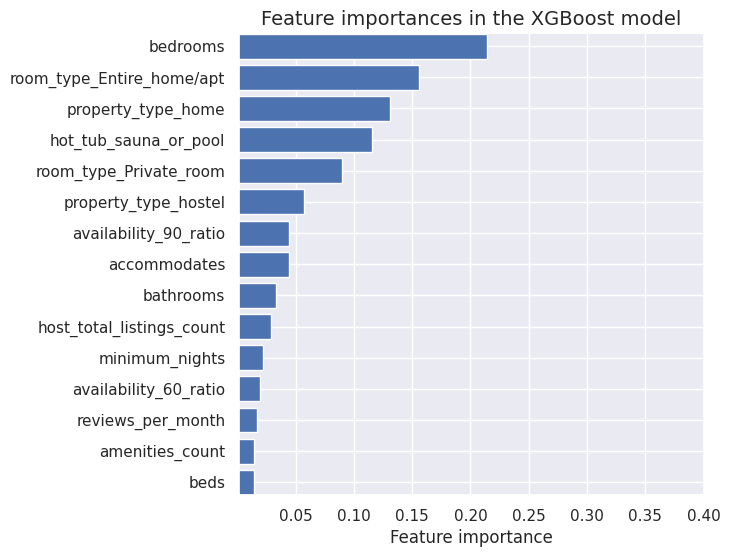

In [ ]:
# Plotting feature importances
ft_weights_xgb_reg_t = pd.DataFrame(xgb_reg_t.feature_importances_, columns=['weight'], index=X_train_t.columns)
ft_weights_xgb_reg_t.sort_values('weight', inplace=True)
plt.figure(figsize=(6,6))
plt.barh(ft_weights_xgb_reg_t.index, ft_weights_xgb_reg_t.weight, align='center')
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.001)
plt.xlim(0.001, 0.4)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train a RandomForestRegressor with specified parameters
random_forest_regressor = RandomForestRegressor(
    max_depth=100,
    n_estimators=2000,
    random_state=0
)
random_forest_regressor.fit(X_train_t, y_train_t)

# Predict on the training and testing sets
rf_train_predictions = random_forest_regressor.predict(X_train_t)
rf_test_predictions = random_forest_regressor.predict(X_test_t)

# Evaluate the model using regression metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Calculate metrics for training and testing sets
train_metrics = evaluate_model(y_train_t, rf_train_predictions)
test_metrics = evaluate_model(y_test_t, rf_test_predictions)

# Print the evaluation metrics
print("Training Set Metrics:")
print(f"MAE: {train_metrics[0]}")
print(f"MSE: {train_metrics[1]}")
print(f"RMSE: {train_metrics[2]}")
print(f"R²: {train_metrics[3]}")

print("\nTesting Set Metrics:")
print(f"MAE: {test_metrics[0]}")
print(f"MSE: {test_metrics[1]}")
print(f"RMSE: {test_metrics[2]}")
print(f"R²: {test_metrics[3]}")


In [ ]:
# Tune the Random Forest Regressor parameters
tuned_rf = RandomForestRegressor(
    n_estimators=2000,             # Reduced from 2000 for efficiency
    max_depth=100,                  # Limit depth to avoid overfitting
    min_samples_split=2,          # Increase to reduce overfitting
    min_samples_leaf=10,            # Increase leaf size for regularization
    max_features='sqrt',           # Add randomness to feature selection
    max_leaf_nodes=100,             # Further constrain tree complexity
    random_state=0,
    bootstrap=True                 # Default bootstrap sampling for robustness
)

# Fit the model
tuned_rf.fit(X_train_t, y_train_t)

# Predict on the training and testing sets
train_predictions = tuned_rf.predict(X_train_t)
test_predictions = tuned_rf.predict(X_test_t)

# Evaluate the tuned model
train_metrics = evaluate_model(y_train_t, train_predictions)
test_metrics = evaluate_model(y_test_t, test_predictions)

# Print metrics
print("\nTuned Model Metrics:")
print("Training Set Metrics:")
print(f"MAE: {train_metrics[0]}")
print(f"MSE: {train_metrics[1]}")
print(f"RMSE: {train_metrics[2]}")
print(f"R²: {train_metrics[3]}")

print("\nTesting Set Metrics:")
print(f"MAE: {test_metrics[0]}")
print(f"MSE: {test_metrics[1]}")
print(f"RMSE: {test_metrics[2]}")
print(f"R²: {test_metrics[3]}")